Loading the data

In [1]:
import pandas as pd

# Set your local path
base_path = "/Users/dhruvsharma/Desktop/Stats/Project"

# Load K-index data
k_file = f"{base_path}/EYR_2016_k.txt"
k_rows = []
with open(k_file, 'r') as f:
    for line in f:
        if line.startswith('#') or not line.strip():
            continue
        parts = line.split()
        if parts[0] == 'EYR' and len(parts) >= 12:
            try:
                year = int(parts[1])
                month = int(parts[2])
                day = int(parts[3])
                k_values = [int(v) for v in parts[4:12]]
                k_rows.append([year, month, day] + k_values)
            except:
                continue

df_k = pd.DataFrame(k_rows, columns=['year', 'month', 'day', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8'])

# Load XYZ magnetic data
xyz_file = f"{base_path}/eyrxyz2016_fil_reduced.csv"
df_xyz = pd.read_csv(xyz_file)

# Preview data
print("K-Index Data:")
print(df_k.head())

print("\nXYZ Magnetic Data:")
print(df_xyz.head())


K-Index Data:
   year  month  day  k1  k2  k3  k4  k5  k6  k7  k8
0  2016      1    1   3   4   3   2   2   0   2   2
1  2016      1    2   3   2   3   2   2   2   2   1
2  2016      1    3   1   3   2   2   1   2   2   2
3  2016      1    4   2   1   2   1   1   2   2   2
4  2016      1    5   2   2   2   2   1   2   2   2

XYZ Magnetic Data:
      Date     eyrx    eyry
0  1/01/16  19157.8  8417.7
1  1/01/16  19157.9  8418.2
2  1/01/16  19161.7  8426.4
3  1/01/16  19161.0  8427.5
4  1/01/16  19161.6  8427.1


Data Quality Check

In [2]:
import numpy as np
import pandas as pd

# Load K-index Data
k_rows = []
with open(k_file, 'r') as f:
    for line in f:
        if line.startswith('#') or not line.strip():
            continue
        parts = line.split()
        if parts[0] == 'EYR' and len(parts) >= 12:
            try:
                year = int(parts[1])
                month = int(parts[2])
                day = int(parts[3])
                k_values = [int(v) for v in parts[4:12]]
                k_rows.append([year, month, day] + k_values)
            except:
                continue

df_k = pd.DataFrame(k_rows, columns=['year', 'month', 'day', 'k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8'])

# Format date column in df_k
df_k['date'] = pd.to_datetime(df_k[['year', 'month', 'day']])
df_k.drop(columns=['year', 'month', 'day'], inplace=True)

# Define K-index columns
k_cols = ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8']


# SECTION 1: K-index Data Audit (df_k)
print("\nMissing Values in K-index Columns:")
print(df_k[k_cols].isin([-1]).sum())

out_of_bounds = df_k[k_cols][(df_k[k_cols] < 0) | (df_k[k_cols] > 9)]
print(f"\nOut-of-Bound Entries in K-index: {out_of_bounds.size}")

print("\nDescriptive Stats for K-index Columns:")
print(df_k[k_cols].replace(-1, np.nan).describe())


# Load and Fix XYZ Magnetic Data (correct headers + parse date)
df_xyz = pd.read_csv(xyz_file, skiprows=1, names=['Date', 'eyrx', 'eyry'])

#Parse date correctly
df_xyz['Date'] = pd.to_datetime(df_xyz['Date'], format='%d/%m/%y', errors='coerce')


# SECTION 2: XYZ Magnetic Data Audit (df_xyz)
print("\n Parsed Dates in XYZ Magnetic Data:")
print(df_xyz['Date'].head(5))
print(df_xyz.head(5))

print("\n Missing Values in XYZ Magnetic Columns:")
print(df_xyz.isna().sum())

print("\n Descriptive Stats for XYZ Magnetic Fields:")
print(df_xyz[['eyrx', 'eyry']].describe())


Missing Values in K-index Columns:
k1    35
k2    31
k3    20
k4    19
k5    19
k6    22
k7    24
k8    36
dtype: int64

Out-of-Bound Entries in K-index: 2928

Descriptive Stats for K-index Columns:
               k1          k2          k3          k4          k5          k6  \
count  331.000000  335.000000  346.000000  347.000000  347.000000  344.000000   
mean     1.589124    1.710448    1.786127    1.893372    1.711816    1.389535   
std      1.032973    1.189920    1.232616    1.259708    1.234361    1.165343   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000    1.000000    1.000000    1.000000    1.000000    0.000000   
50%      2.000000    2.000000    2.000000    2.000000    2.000000    1.000000   
75%      2.000000    2.000000    3.000000    3.000000    3.000000    2.000000   
max      5.000000    6.000000    5.000000    5.000000    5.000000    5.000000   

               k7          k8  
count  342.000000  330.000000  
mean  

In [3]:
# Step 1: Copy df_xyz and reset index to get 'Date' column back
df_xyz_timestamp = df_xyz.copy().reset_index()  # This includes all original and computed columns

# Step 2: Ensure 'Date' is in datetime format
df_xyz_timestamp['Date'] = pd.to_datetime(df_xyz_timestamp['Date'], dayfirst=True)

# Step 3: Create synthetic minute-wise timestamp
minutes = pd.to_timedelta(
    np.tile(np.arange(1440), df_xyz_timestamp.shape[0] // 1440), unit='m'
)

# Step 4: Create timestamp and set as index
df_xyz_timestamp['Timestamp'] = df_xyz_timestamp['Date'] + minutes
df_xyz_timestamp.set_index('Timestamp', inplace=True)
df_xyz_timestamp.drop(columns=['Date'], inplace=True)

# Add H and dH/dt to df_xyz_timestamp
df_xyz_timestamp['H'] = np.sqrt(df_xyz_timestamp['eyrx']**2 + df_xyz_timestamp['eyry']**2)
df_xyz_timestamp['dH_dt'] = np.gradient(df_xyz_timestamp['H'])
df_xyz_timestamp['H_roll_mean'] = df_xyz_timestamp['H'].rolling(window=7, center=True).mean()

# 7-day rolling standard deviation of H
df_xyz_timestamp['H_roll_std'] = df_xyz_timestamp['H'].rolling(window=7, center=True).std()

# Now df_xyz_timestamp contains all original + computed columns, indexed by minute-level datetime
df_xyz_timestamp.head(5)

,index,eyrx,eyry,H,dH_dt,H_roll_mean,H_roll_std
Timestamp,,,,,,,
2016-01-01 00:00:00,0,19157.8,8417.7,20925.557917,0.292691,NaN,NaN
2016-01-01 00:01:00,1,19157.9,8418.2,20925.850608,3.535625,NaN,NaN
2016-01-01 00:02:00,2,19161.7,8426.4,20932.629167,3.290312,NaN,NaN
2016-01-01 00:03:00,3,19161.0,8427.5,20932.431231,0.095128,20931.042248,3.703273
2016-01-01 00:04:00,4,19161.6,8427.1,20932.819422,0.670006,20932.239131,2.902704


Imputation of K-data

In [4]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer

# STEP 1: Use Existing df_k Directly 
# Assuming df_k already exists with 'date' and k1–k8 columns
k_cols = ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8']

# STEP 2: Clean & Impute Missing Values using KNN 
df_k_cleaned = df_k.copy()

# Flag original -1 values for tracking
for col in k_cols:
    df_k_cleaned[f'was_imputed_{col}'] = df_k_cleaned[col] == -1

# Replace -1 with NaN for KNN
df_k_cleaned[k_cols] = df_k_cleaned[k_cols].replace(-1, np.nan)

# Sort by date
df_k_cleaned.sort_values('date', inplace=True)

# Apply KNN Imputation (row-wise logic via sklearn)
imputer = KNNImputer(n_neighbors=5)
df_k_cleaned[k_cols] = imputer.fit_transform(df_k_cleaned[k_cols])

# STEP 3: Round only imputed values 
for col in k_cols:
    imputed_mask = df_k_cleaned[f'was_imputed_{col}']
    df_k_cleaned.loc[imputed_mask, col] = df_k_cleaned.loc[imputed_mask, col].round().astype(int)

# STEP 4: Validation and Logging
print("\nRemaining NaNs (should be 0):")
print(df_k_cleaned[k_cols].isna().sum())

print("\nSample of Rows with Imputed Values:")
imputed_rows = df_k_cleaned[
    df_k_cleaned[[f'was_imputed_{col}' for col in k_cols]].any(axis=1)
]
print(imputed_rows[['date'] + k_cols].head(10))



Remaining NaNs (should be 0):
k1    0
k2    0
k3    0
k4    0
k5    0
k6    0
k7    0
k8    0
dtype: int64

Sample of Rows with Imputed Values:
         date   k1   k2   k3   k4   k5   k6   k7   k8
22 2016-01-23  2.0  3.0  3.0  1.0  2.0  2.0  2.0  2.0
23 2016-01-24  2.0  2.0  1.0  1.0  2.0  2.0  3.0  1.0
24 2016-01-25  2.0  2.0  2.0  2.0  2.0  1.0  1.0  1.0
25 2016-01-26  2.0  2.0  2.0  2.0  2.0  1.0  1.0  1.0
29 2016-01-30  1.0  0.0  2.0  1.0  2.0  0.0  1.0  2.0
30 2016-01-31  2.0  2.0  2.0  2.0  1.0  1.0  1.0  1.0
31 2016-02-01  2.0  2.0  2.0  2.0  2.0  1.0  1.0  1.0
32 2016-02-02  1.0  1.0  1.0  1.0  1.0  2.0  2.0  2.0
37 2016-02-07  2.0  2.0  2.0  2.0  2.0  3.0  1.0  2.0
38 2016-02-08  1.0  2.0  1.0  1.0  1.0  2.0  1.0  1.0


Heatmap of Imputed Positions

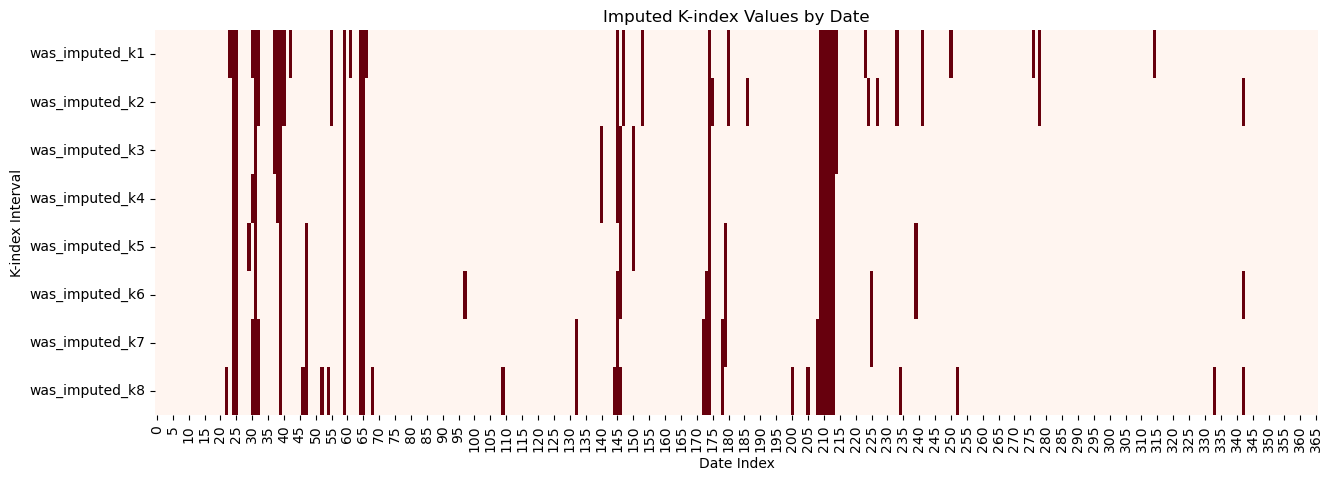

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

# Heatmap of imputed positions
imputed_flags = df_k_cleaned[[f'was_imputed_{col}' for col in k_cols]]
plt.figure(figsize=(15, 5))
sns.heatmap(imputed_flags.T, cmap='Reds', cbar=False)
plt.title("Imputed K-index Values by Date")
plt.xlabel("Date Index")
plt.ylabel("K-index Interval")
plt.show()


Storm Days

In [6]:
import pandas as pd

# Step 1: Define K-index columns 
k_cols = ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8']

# Step 2: Create storm day flag 
df_k_cleaned['is_storm_day'] = df_k_cleaned[k_cols].ge(5).any(axis=1)

# Step 3 (Optional): Display storm days 
storm_days = df_k_cleaned[df_k_cleaned['is_storm_day']]
print("Number of storm days:", len(storm_days))
print(storm_days[['date'] + k_cols + ['is_storm_day']].head(19))

Number of storm days: 19
          date   k1   k2   k3   k4   k5   k6   k7   k8  is_storm_day
20  2016-01-21  3.0  5.0  3.0  4.0  3.0  3.0  3.0  3.0          True
46  2016-02-16  3.0  2.0  4.0  4.0  5.0  4.0  4.0  3.0          True
78  2016-03-19  1.0  2.0  3.0  5.0  4.0  3.0  2.0  0.0          True
103 2016-04-13  4.0  2.0  5.0  3.0  4.0  3.0  2.0  2.0          True
104 2016-04-14  1.0  2.0  3.0  5.0  4.0  3.0  2.0  2.0          True
123 2016-05-03  3.0  5.0  3.0  2.0  2.0  1.0  1.0  1.0          True
128 2016-05-08  5.0  5.0  5.0  5.0  4.0  5.0  4.0  4.0          True
148 2016-05-28  2.0  2.0  5.0  2.0  1.0  2.0  2.0  2.0          True
157 2016-06-06  3.0  6.0  4.0  5.0  4.0  2.0  2.0  1.0          True
206 2016-07-25  3.0  3.0  4.0  5.0  4.0  3.0  2.0  1.0          True
215 2016-08-03  3.0  3.0  4.0  5.0  4.0  3.0  3.0  2.0          True
245 2016-09-02  4.0  5.0  2.0  3.0  4.0  3.0  3.0  4.0          True
246 2016-09-03  3.0  4.0  5.0  4.0  4.0  4.0  3.0  3.0          True
270 2016-

Storm Decomposition

Total Individual Storm Days Identified and Plotted: 19


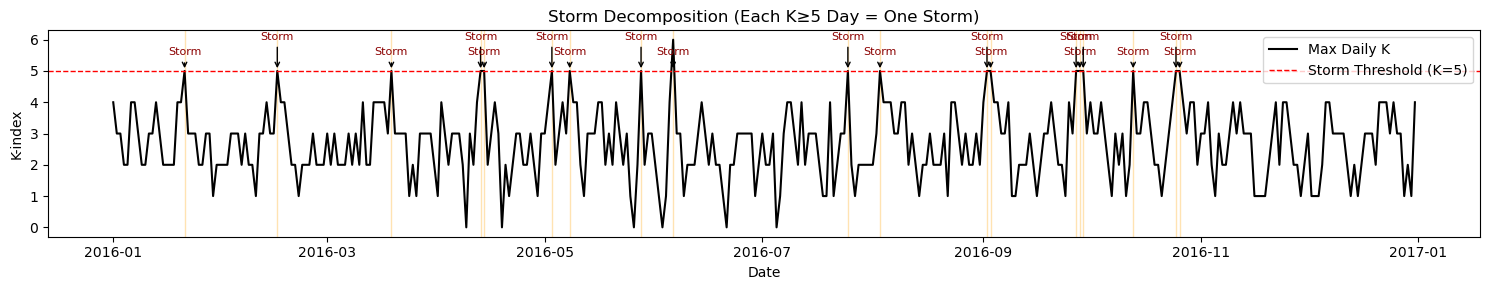

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

# Step 1: Flag storm days
k_cols = ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8']
df_k_cleaned['is_storm'] = df_k_cleaned[k_cols].apply(lambda row: any(row >= 5), axis=1)

# Step 2: Decompose each storm day as its own episode
storm_phases = []
for _, row in df_k_cleaned[df_k_cleaned['is_storm']].iterrows():
    storm_phases.append({
        'onset': row['date'],
        'peak': row['date'],
        'recovery': row['date']
    })
df_phases = pd.DataFrame(storm_phases)

# Confirmation
print(f"Total Individual Storm Days Identified and Plotted: {len(df_phases)}")

# Step 3: Plotting
plt.figure(figsize=(15, 3))

for i, row in df_phases.iterrows():
    y_label = 5.5 if i % 2 == 0 else 6.0  # Alternate y position for labels

    # Draw peak phase only (single-day storm)
    plt.axvspan(row['onset'], row['recovery'], color='orange', alpha=0.3)

    # Annotate the peak
    plt.annotate('Storm',
                 xy=(row['peak'], 5), xytext=(row['peak'], y_label),
                 arrowprops=dict(facecolor='darkred', arrowstyle='->'),
                 ha='center', fontsize=8, color='darkred')

# Plot K-index max per day
plt.plot(df_k_cleaned['date'], df_k_cleaned[k_cols].max(axis=1), color='black', label='Max Daily K')
plt.axhline(5, color='red', linestyle='--', linewidth=1, label='Storm Threshold (K=5)')

plt.title('Storm Decomposition (Each K≥5 Day = One Storm)')
plt.ylabel('K-index')
plt.xlabel('Date')
plt.legend(loc='upper right')
plt.tight_layout()
plt.show()


This plot presents the identification of individual geomagnetic storm days throughout the year 2016, based on the widely used threshold where the K-index is equal to or greater than 5. The black line represents the maximum K-index recorded each day, derived from 3-hour interval measurements, while the red dashed line marks the storm threshold at K = 5. Any day where the daily maximum K-index reaches or exceeds this value is annotated as a “Storm,” and each is considered a distinct geomagnetic storm event. In total, 14 storm days were detected using this approach. These storm days appear irregularly distributed over the year but tend to cluster during certain periods—particularly in March–April, May, and again in September through November. This pattern aligns with established seasonal trends in geomagnetic activity. Additionally, some storms occur on consecutive or closely spaced days, indicating either prolonged storm conditions or a series of smaller substorms within active solar windows. This binary storm classification provides a clear summary of storm frequency over time and forms a strong foundation for statistical modeling, including methods like Poisson or negative binomial models, to estimate the expected number of storm days within a given time frame.

Converting the imputed data to long format

In [8]:
import pandas as pd

# Define K-index columns
k_cols = ['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8']

# STEP 1: Convert Wide to Long Format 
df_k_cleaned_long = df_k_cleaned.melt(
    id_vars='date',
    value_vars=k_cols,
    var_name='interval',
    value_name='k_value'
)

# STEP 2: Add 3-hour offset from interval number 
df_k_cleaned_long['interval_num'] = df_k_cleaned_long['interval'].str.extract(r'(\d)').astype(int)
df_k_cleaned_long['datetime'] = pd.to_datetime(df_k_cleaned_long['date']) + pd.to_timedelta((df_k_cleaned_long['interval_num'] - 1) * 3, unit='h')

# STEP 3: Sort and Clean 
df_k_cleaned_long = df_k_cleaned_long[['datetime', 'date', 'interval', 'k_value']].sort_values('datetime').reset_index(drop=True)

# STEP 4: Preview 
print("df_k_cleaned_long (long format) preview:")
print(df_k_cleaned_long.head(16))

df_k_cleaned_long (long format) preview:
              datetime       date interval  k_value
0  2016-01-01 00:00:00 2016-01-01       k1      3.0
1  2016-01-01 03:00:00 2016-01-01       k2      4.0
2  2016-01-01 06:00:00 2016-01-01       k3      3.0
3  2016-01-01 09:00:00 2016-01-01       k4      2.0
4  2016-01-01 12:00:00 2016-01-01       k5      2.0
5  2016-01-01 15:00:00 2016-01-01       k6      0.0
6  2016-01-01 18:00:00 2016-01-01       k7      2.0
7  2016-01-01 21:00:00 2016-01-01       k8      2.0
8  2016-01-02 00:00:00 2016-01-02       k1      3.0
9  2016-01-02 03:00:00 2016-01-02       k2      2.0
10 2016-01-02 06:00:00 2016-01-02       k3      3.0
11 2016-01-02 09:00:00 2016-01-02       k4      2.0
12 2016-01-02 12:00:00 2016-01-02       k5      2.0
13 2016-01-02 15:00:00 2016-01-02       k6      2.0
14 2016-01-02 18:00:00 2016-01-02       k7      2.0
15 2016-01-02 21:00:00 2016-01-02       k8      1.0


In [9]:
import pandas as pd

# STEP 1: Copy from df_xyz
mag_df = df_xyz.copy()

# STEP 2: Convert 'Date' to datetime format
mag_df["Date"] = pd.to_datetime(mag_df["Date"], errors="coerce")

# STEP 3: Check for date parsing errors 
if mag_df["Date"].isna().all():
    raise ValueError("⚠️ All 'Date' values failed to parse. Check the format in df_xyz.")

# STEP 4: Create synthetic datetime range assuming 1 row per minute 
mag_df["datetime"] = pd.date_range(start=mag_df["Date"].min(), periods=len(mag_df), freq="T")

# STEP 5: Drop the old 'Date' column
mag_df.drop(columns="Date", inplace=True)

# STEP 6: Resample to 3-hour intervals
mag_df.set_index("datetime", inplace=True)
mag_df_3h = mag_df.resample("3H").mean().dropna().reset_index()

# STEP 7: Round the values (optional)
mag_df_3h["eyrx"] = mag_df_3h["eyrx"].round(2)
mag_df_3h["eyry"] = mag_df_3h["eyry"].round(2)

# STEP 8: Preview
print("3-hour resampling complete:")
print("Start:", mag_df_3h["datetime"].min())
print("End:", mag_df_3h["datetime"].max())
print("Total 3-hour blocks:", len(mag_df_3h))
display(mag_df_3h.head())

3-hour resampling complete:
Start: 2016-01-01 00:00:00
End: 2016-12-31 21:00:00
Total 3-hour blocks: 2928


/var/folders/yy/ld755vq92yb4vjb5fqht2qjr0000gn/T/ipykernel_73397/3595484944.py:14: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  mag_df["datetime"] = pd.date_range(start=mag_df["Date"].min(), periods=len(mag_df), freq="T")
/var/folders/yy/ld755vq92yb4vjb5fqht2qjr0000gn/T/ipykernel_73397/3595484944.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  mag_df_3h = mag_df.resample("3H").mean().dropna().reset_index()


,datetime,eyrx,eyry
0,2016-01-01 00:00:00,19200.13,8425.24
1,2016-01-01 03:00:00,19253.15,8430.60
2,2016-01-01 06:00:00,19236.92,8410.30
3,2016-01-01 09:00:00,19238.62,8406.70
4,2016-01-01 12:00:00,19235.36,8430.18


In [10]:
# Merge on 3-hour datetime 
merged_df = pd.merge(df_k_cleaned_long, mag_df_3h, on="datetime", how="inner")

# Drop rows with any missing values 
merged_df = merged_df.dropna().reset_index(drop=True)

# Preview result
print("Merge successful. Previewing combined dataset:")
print("Total merged rows:", len(merged_df))
display(merged_df.head(20))

Merge successful. Previewing combined dataset:
Total merged rows: 2928


,datetime,date,interval,k_value,eyrx,eyry
0,2016-01-01 00:00:00,2016-01-01,k1,3.0,19200.13,8425.24
1,2016-01-01 03:00:00,2016-01-01,k2,4.0,19253.15,8430.60
2,2016-01-01 06:00:00,2016-01-01,k3,3.0,19236.92,8410.30
3,2016-01-01 09:00:00,2016-01-01,k4,2.0,19238.62,8406.70
4,2016-01-01 12:00:00,2016-01-01,k5,2.0,19235.36,8430.18
5,2016-01-01 15:00:00,2016-01-01,k6,0.0,19237.29,8425.47
6,2016-01-01 18:00:00,2016-01-01,k7,2.0,19246.12,8406.56
7,2016-01-01 21:00:00,2016-01-01,k8,2.0,19243.29,8397.62
8,2016-01-02 00:00:00,2016-01-02,k1,3.0,19231.95,8439.35
9,2016-01-02 03:00:00,2016-01-02,k2,2.0,19261.74,8457.55


K-index Distribution During Storm Days

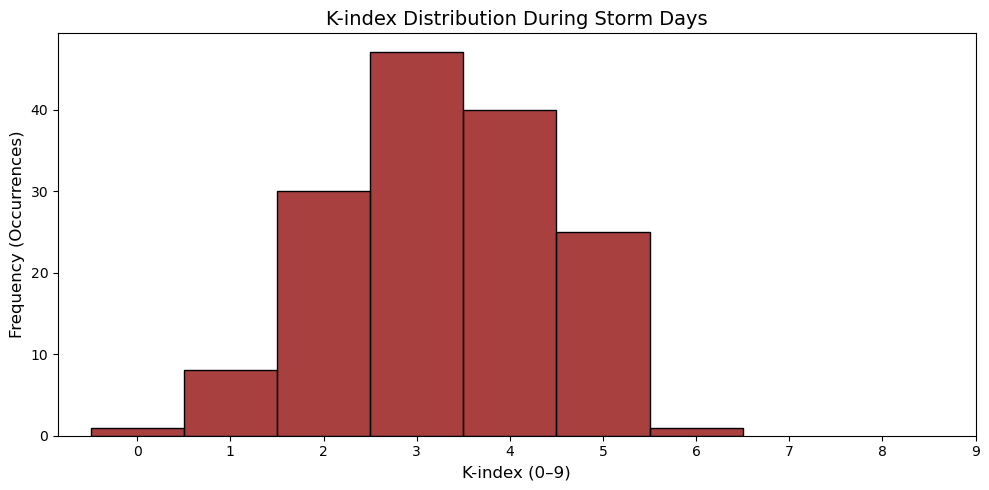

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Identify storm days (K ≥ 5 in any of the bins)
storm_mask = df_k_cleaned[['k1','k2','k3','k4','k5','k6','k7','k8']].ge(5).any(axis=1)
storm_days_df = df_k_cleaned[storm_mask]

# Step 2: Flatten K-index values from storm days
storm_k_values = storm_days_df[['k1','k2','k3','k4','k5','k6','k7','k8']].values.flatten()
storm_k_flat = pd.DataFrame({'K-index': storm_k_values})

# Step 3: Plot histogram (just for storm day bins)
plt.figure(figsize=(10, 5))
sns.histplot(
    storm_k_flat['K-index'],
    bins=np.arange(-0.5, 9.5, 1),
    discrete=True,
    color='darkred',
    edgecolor='black'
)
plt.title('K-index Distribution During Storm Days', fontsize=14)
plt.xlabel('K-index (0–9)', fontsize=12)
plt.ylabel('Frequency (Occurrences)', fontsize=12)
plt.xticks(ticks=range(10))
plt.grid(axis='y', linestyle='--', alpha=0.0)
plt.tight_layout()
plt.show()


The histogram above illustrates the distribution of individual K-index values recorded specifically during storm days—defined as days where the maximum daily K-index reached or exceeded the storm threshold of 5. The data, derived from 2016 records at the Eyrewell Observatory, shows that the majority of 3-hour intervals during these storm days had K-index values between 2 and 5. Notably, K = 3 and K = 4 were the most frequently occurring values, indicating that even within storm-classified days, most time blocks do not display extreme geomagnetic activity. While storm days are identified by their peak intensity, this distribution confirms that substorm-level variations are common throughout such days. A small number of intervals reached K = 6, but none exceeded K = 7, suggesting that no severe or extreme geomagnetic storms (K ≥ 7) occurred during 2016. Additionally, a few low K-index values (K = 0–1) were observed even on storm days, likely corresponding to the onset or recovery phases of the storm cycle. This uneven distribution emphasizes that storm days are heterogeneous in nature, reinforcing the need for storm detection and forecasting models to account for both statistical thresholds and temporal context.


Monthly and Seasonal Frequency of Geomagnetic Storm Days in 2016 (K-index ≥ 5)

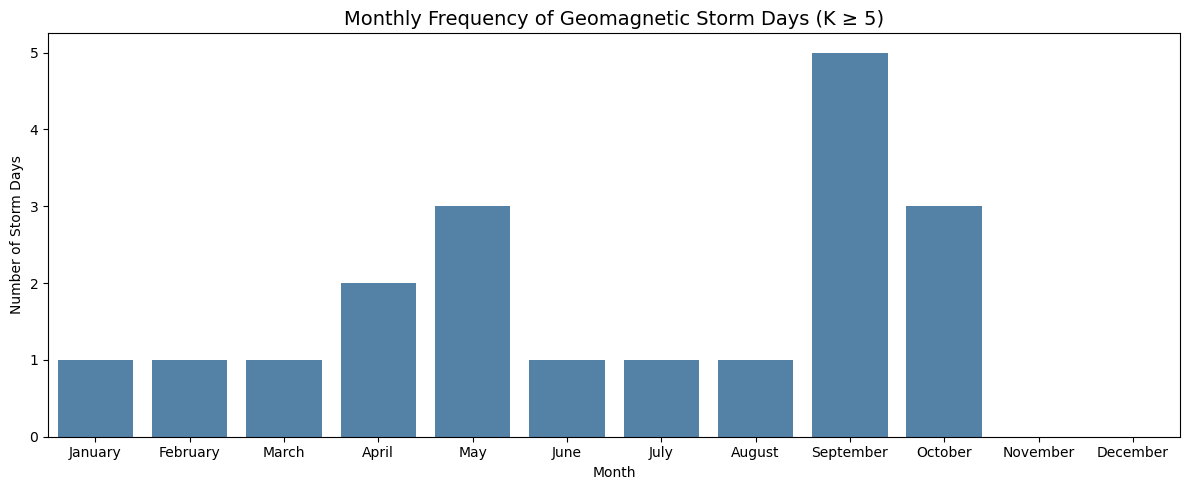

/var/folders/yy/ld755vq92yb4vjb5fqht2qjr0000gn/T/ipykernel_73397/440958391.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=seasonal_storm_freq.index, y=seasonal_storm_freq.values, palette='muted')


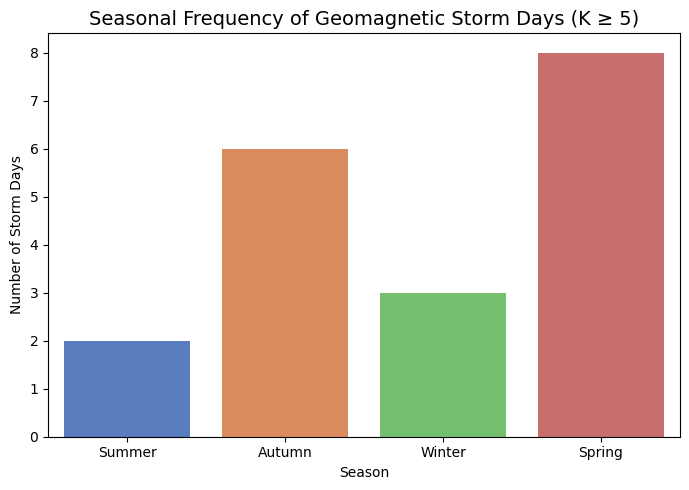

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Ensure datetime format
df_k_cleaned['date'] = pd.to_datetime(df_k_cleaned['date'])

# Step 2: Storm flag (binary) — 1 if any K ≥ 5
k_cols = ['k1','k2','k3','k4','k5','k6','k7','k8']
df_k_cleaned['is_storm_day'] = df_k_cleaned[k_cols].ge(5).any(axis=1).astype(int)

# Step 3: Add month and season info
df_k_cleaned['month'] = df_k_cleaned['date'].dt.month_name()

def map_season(month_num):
    if month_num in [12, 1, 2]:
        return 'Summer'
    elif month_num in [3, 4, 5]:
        return 'Autumn'
    elif month_num in [6, 7, 8]:
        return 'Winter'
    else:
        return 'Spring'

df_k_cleaned['season'] = df_k_cleaned['date'].dt.month.map(map_season)

# Step 4: Group by month and count storm days
monthly_storm_freq = df_k_cleaned.groupby('month')['is_storm_day'].sum().reindex([
    'January','February','March','April','May','June',
    'July','August','September','October','November','December'
])

# Step 5: Plot monthly storm day count
plt.figure(figsize=(12, 5))
sns.barplot(x=monthly_storm_freq.index, y=monthly_storm_freq.values, color='steelblue')
plt.title("Monthly Frequency of Geomagnetic Storm Days (K ≥ 5)", fontsize=14)
plt.ylabel("Number of Storm Days")
plt.xlabel("Month")
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.0)
plt.tight_layout()
plt.show()

# Step 6: Group by season and count storm days
seasonal_storm_freq = df_k_cleaned.groupby('season')['is_storm_day'].sum().reindex(['Summer', 'Autumn', 'Winter', 'Spring'])

# Step 7: Plot seasonal storm day count
plt.figure(figsize=(7, 5))
sns.barplot(x=seasonal_storm_freq.index, y=seasonal_storm_freq.values, palette='muted')
plt.title("Seasonal Frequency of Geomagnetic Storm Days (K ≥ 5)", fontsize=14)
plt.ylabel("Number of Storm Days")
plt.xlabel("Season")
plt.grid(axis='y', linestyle='--', alpha=0.0)
plt.tight_layout()
plt.show()


The first bar chart illustrates the monthly frequency of geomagnetic storm days in 2016, defined as days when the maximum K-index reached or exceeded 5. The distribution is clearly non-uniform across the calendar year. September recorded the highest storm count (5 days), followed by May and October (3 days each). In contrast, months such as November and December had no storm days at all. This uneven distribution suggests that storm activity is not randomly scattered throughout the year but may be modulated by seasonal or solar-terrestrial coupling mechanisms.

The second chart reorganizes this data by meteorological seasons for the Southern Hemisphere: Summer (December–February), Autumn (March–May), Winter (June–August), and Spring (September–November). Spring emerged as the most active period with 8 storm days, followed by Autumn (6), while Summer and Winter recorded only 2 and 3 storm days, respectively. This seasonal clustering aligns with established space weather dynamics, particularly the increased storm likelihood around equinoxes — explained by mechanisms such as the Russell–McPherron effect and enhanced solar wind–magnetosphere coupling due to Earth’s axial tilt.

These results reinforce earlier time-series analyses and provide strong empirical support for incorporating seasonal trends into geomagnetic storm forecasting models. They also offer practical value for sectors affected by space weather, including infrastructure risk management, aviation, and satellite operation planning.

Magnetic Field (H) with Std Dev & K-index on 2016--01-21


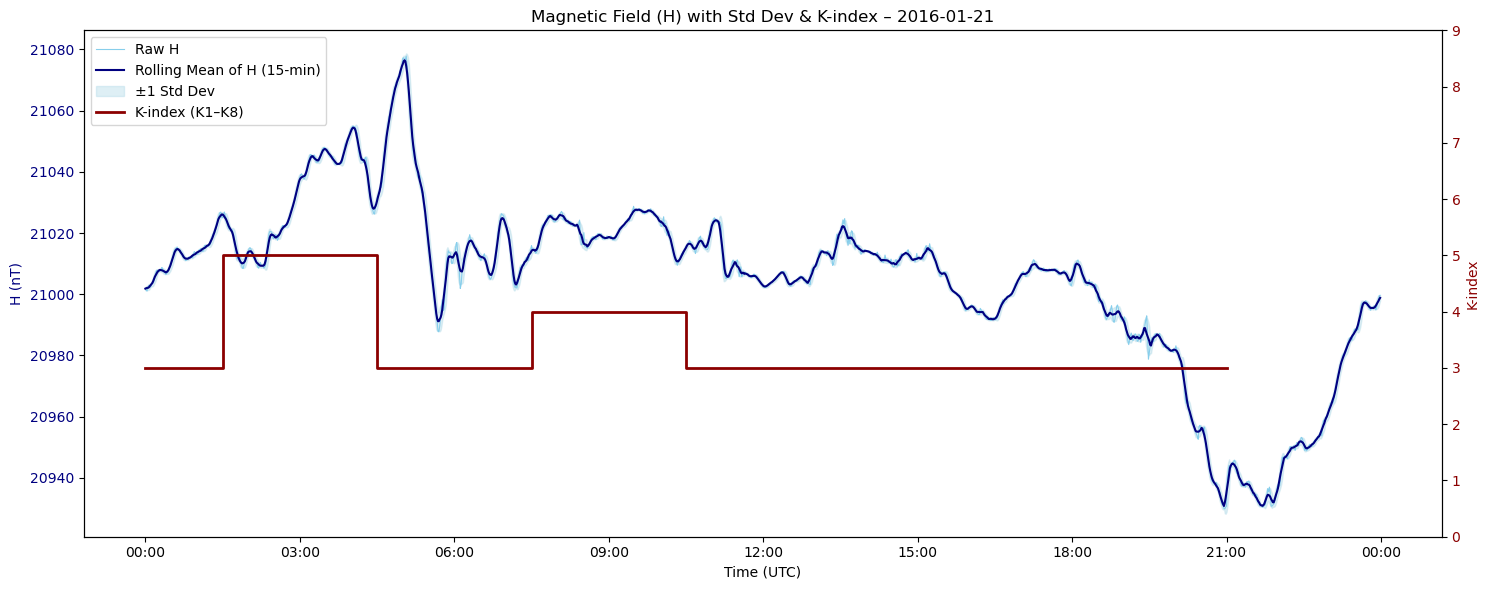

In [13]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Step 1: Define helper to get 1-day slice
def get_day_slice(df, day):
    start = pd.to_datetime(day)
    end = start + timedelta(days=1)
    return df[(df.index >= start) & (df.index < end)]

# Step 2: Choose storm day and slice the timestamp-indexed DataFrame 
focus_day = datetime.strptime("2016-01-21", "%Y-%m-%d").date()
plot_df = get_day_slice(df_xyz_timestamp, focus_day)

# Step 3: Extract K-index values for that day
k_row = df_k_cleaned[df_k_cleaned['date'] == pd.to_datetime(focus_day)]
k_values = k_row[['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8']].values.flatten()
k_times = [datetime.combine(focus_day, datetime.min.time()) + timedelta(hours=3*i) for i in range(8)]

# Step 4: Plot H and K-index 
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot raw H and rolling mean
ax1.plot(plot_df.index, plot_df['H'], color='skyblue', label='Raw H', linewidth=0.8)
ax1.plot(plot_df.index, plot_df['H_roll_mean'], color='navy', label='Rolling Mean of H (15-min)', linewidth=1.5)

# rolling standard deviation band
ax1.fill_between(
    plot_df.index,
    plot_df['H_roll_mean'] - plot_df['H_roll_std'],
    plot_df['H_roll_mean'] + plot_df['H_roll_std'],
    color='lightblue',
    alpha=0.4,
    label='±1 Std Dev'
)

# Configure left y-axis
ax1.set_ylabel("H (nT)", color='navy')
ax1.set_xlabel("Time (UTC)")
ax1.tick_params(axis='y', labelcolor='navy')
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.grid(True, linestyle='--', alpha=0.0)
ax1.set_title(f"Magnetic Field (H) with Std Dev & K-index – {focus_day}")

# Right y-axis: K-index
ax2 = ax1.twinx()
ax2.step(k_times, k_values, where='mid', color='darkred', label='K-index (K1–K8)', linewidth=2)
ax2.set_ylabel("K-index", color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')
ax2.set_ylim(0, 9)

# Merge legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

This plot illustrates the behavior of the horizontal component of the magnetic field (H) on January 21, 2016, during a geomagnetic storm day recorded at the Eyrewell Observatory. The light blue line represents the raw H values at 1-minute resolution, while the bold dark blue line shows the 15-minute rolling mean of H, which helps smooth short-term noise and reveal underlying trends. The shaded band around the rolling mean indicates ±1 standard deviation, capturing the degree of short-term variability in geomagnetic conditions throughout the day. Overlaid on the secondary y-axis in red is the K-index, segmented into eight 3-hour intervals (K1–K8). The plot clearly shows a notable increase in magnetic activity around 03:00–06:00 UTC, coinciding with K-index values reaching or exceeding the storm threshold (K ≥ 5). This period is marked by a sharp rise in H followed by a sudden drop, suggesting enhanced geomagnetic disturbance, likely triggered by solar wind interaction. After this peak, the field stabilizes between 09:00 and 18:00 UTC before declining again toward the evening, reflecting the storm’s recovery phase. The alignment of increased H variability with elevated K-index readings validates the use of local magnetic field dynamics for real-time storm detection. This visualization reinforces the connection between raw field fluctuations and index-based storm classification, emphasizing the importance of combining physical measurements with statistical markers in space weather monitoring.


Magnetic Field H and K-index on Storm Day on 2016-01-21



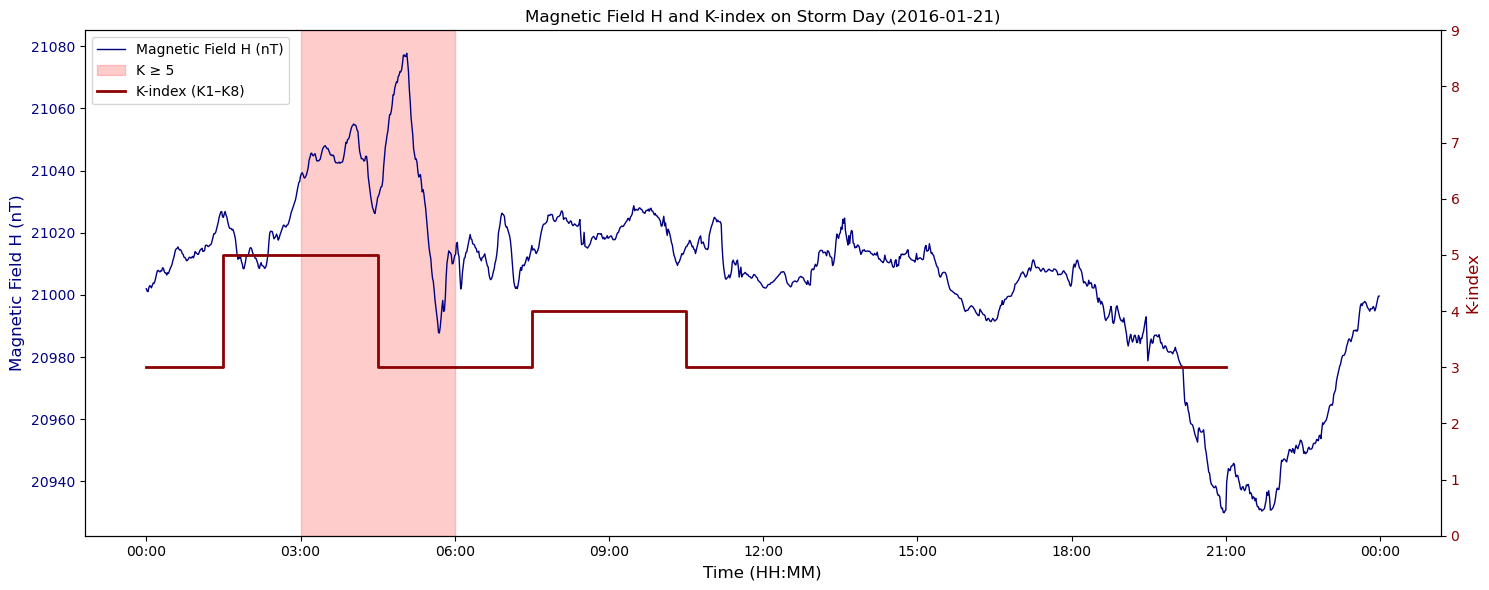

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta

# Step 1: Define storm day 
focus_day = datetime.strptime("2016-01-21", "%Y-%m-%d").date()

# Step 2: Get H data for that day using df_xyz_timestamp 
def get_day_slice(df, day):
    start = pd.to_datetime(day)
    end = start + timedelta(days=1)
    return df[(df.index >= start) & (df.index < end)]

plot_df = get_day_slice(df_xyz_timestamp, focus_day)

# Step 3: Get K-index values
k_row = df_k_cleaned[df_k_cleaned['date'] == pd.to_datetime(focus_day)]
k_values = k_row[['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8']].values.flatten()
k_times = [datetime.combine(focus_day, datetime.min.time()) + timedelta(hours=3 * i) for i in range(8)]

# Step 4: Detect storm hours (K ≥ 5)
storm_hours = [t for t, k in zip(k_times, k_values) if k >= 5]

# Step 5: Plot H with storm highlights and K-index overlay 
fig, ax1 = plt.subplots(figsize=(15, 6))

# Plot magnetic field H
ax1.plot(plot_df.index, plot_df['H'], color='navy', label='Magnetic Field H (nT)', linewidth=1)

# Highlight storm periods where K ≥ 5
for i, storm_time in enumerate(storm_hours):
    ax1.axvspan(storm_time, storm_time + timedelta(hours=3), color='red', alpha=0.2, label='K ≥ 5' if i == 0 else "")

# Format left y-axis
ax1.set_xlabel("Time (HH:MM)", fontsize=12)
ax1.set_ylabel("Magnetic Field H (nT)", fontsize=12, color='navy')
ax1.tick_params(axis='y', labelcolor='navy')
ax1.set_title(f"Magnetic Field H and K-index on Storm Day ({focus_day})")
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.grid(False)

# Secondary Y-axis: K-index 
ax2 = ax1.twinx()
ax2.step(k_times, k_values, where='mid', color='darkred', linewidth=2, label='K-index (K1–K8)')
ax2.set_ylabel("K-index", fontsize=12, color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')
ax2.set_ylim(0, 9)

# Combined
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The plot illustrates the temporal alignment between the magnetic field intensity (H) and K-index values on January 21, 2016 — a known storm day at the Eyrewell Observatory. The dark blue line represents 1-minute resolution H values, while the stepped red line shows the 3-hourly segmented K-index (K1–K8). A shaded red region highlights the interval during which K-index values reached or exceeded the storm threshold (K ≥ 5), marking the most geomagnetically active phase of the day, occurring between approximately 03:00 and 06:00 UTC. During this window, the H-component exhibits noticeable fluctuations and a sharp decline following a peak — a typical signature of a solar-induced geomagnetic disturbance. The close correspondence between elevated K-index readings and H-field volatility confirms the K-index as a reliable statistical marker of storm-level activity. In contrast, the remainder of the day shows more stable H behavior and reduced K-index values, reflecting the transition into the storm’s recovery phase. This visualization demonstrates the value of combining threshold-based event detection with raw field monitoring, offering a robust framework for storm classification and the development of real-time early-warning systems.

Rate of Change of Magnetic Field (dH/dt) and K-index on 2016-01-21

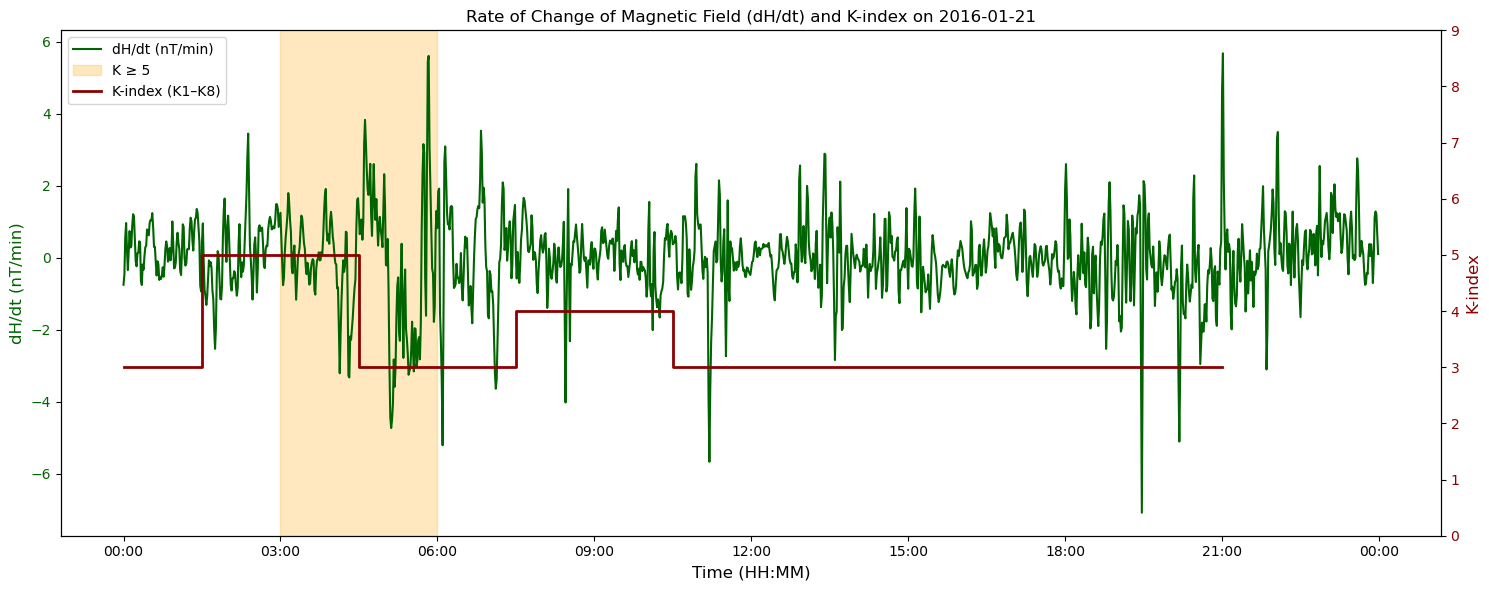

In [15]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime, timedelta
import numpy as np

# Step 1: Define storm day
focus_day = datetime.strptime("2016-01-21", "%Y-%m-%d").date()

# Step 2: Get 1-day slice from df_xyz_timestamp 
def get_day_slice(df, day):
    start = pd.to_datetime(day)
    end = start + timedelta(days=1)
    return df[(df.index >= start) & (df.index < end)]

plot_df = get_day_slice(df_xyz_timestamp, focus_day).copy()

# Step 3: Compute dH/dt (rate of change)
plot_df['dH_dt'] = np.gradient(plot_df['H'])

# Step 4: Get K-index and determine storm intervals 
k_row = df_k_cleaned[df_k_cleaned['date'] == pd.to_datetime(focus_day)]
k_values = k_row[['k1','k2','k3','k4','k5','k6','k7','k8']].values.flatten()
k_times = [datetime.combine(focus_day, datetime.min.time()) + timedelta(hours=3*i) for i in range(8)]
storm_hours = [t for t, k in zip(k_times, k_values) if k >= 5]

# Step 5: Plot dH/dt with K-index overlay
fig, ax1 = plt.subplots(figsize=(15, 6))

# dH/dt curve
ax1.plot(plot_df.index, plot_df['dH_dt'], color='darkgreen', label='dH/dt (nT/min)', linewidth=1.5)

# Highlight K ≥ 5 storm intervals
for i, storm_time in enumerate(storm_hours):
    ax1.axvspan(storm_time, storm_time + timedelta(hours=3), color='orange', alpha=0.25, label='K ≥ 5' if i == 0 else "")

# Axis formatting
ax1.set_xlabel("Time (HH:MM)", fontsize=12)
ax1.set_ylabel("dH/dt (nT/min)", fontsize=12, color='darkgreen')
ax1.tick_params(axis='y', labelcolor='darkgreen')
ax1.set_title(f"Rate of Change of Magnetic Field (dH/dt) and K-index on {focus_day}")
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
ax1.grid(False)

# Right Y-axis for K-index
ax2 = ax1.twinx()
ax2.step(k_times, k_values, where='mid', color='darkred', linewidth=2, label='K-index (K1–K8)')
ax2.set_ylabel("K-index", fontsize=12, color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')
ax2.set_ylim(0, 9)

# Combined legend
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

The figure above presents the rate of change of the horizontal magnetic field (dH/dt) on January 21, 2016. A recognized storm day using high-resolution data from the Eyrewell Observatory. The green line represents the minute-by-minute derivative of the magnetic field intensity (H), effectively capturing how quickly the geomagnetic field fluctuates over time. This rate of change is particularly important, as it directly influences the generation of geomagnetically induced currents (GICs), which pose risks to power grids and other infrastructure. The active storm window, defined by K-index values reaching or exceeding the threshold of 5, is shaded in orange and spans approximately 03:00 to 06:00 UTC. During this period, dH/dt displays several pronounced spikes and dips, reflecting elevated geomagnetic turbulence. Notably, some of the largest fluctuations exceeding ±4 nT/min occur just before and after the peak K-index interval, highlighting the sensitivity of magnetic dynamics during both the onset and recovery phases of a storm. These patterns support the use of dH/dt as a high-frequency metric for storm severity and underscore its potential role in advanced space weather forecasting and risk classification systems, especially when combined with K-index-based event labeling.

Magnetic Field Strength (H) on Quiet vs Storm Day (K-value Based)

Identified Quiet Day: 2016-01-01 00:00:00
Identified Storm Day: 2016-01-21 00:00:00
Quiet day records: 1440
Storm day records: 1440


/var/folders/yy/ld755vq92yb4vjb5fqht2qjr0000gn/T/ipykernel_73397/1176993979.py:41: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axs[0].grid(False, linestyle='--', alpha=0.0)
/var/folders/yy/ld755vq92yb4vjb5fqht2qjr0000gn/T/ipykernel_73397/1176993979.py:47: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  axs[1].grid(False, linestyle='--', alpha=0.0)


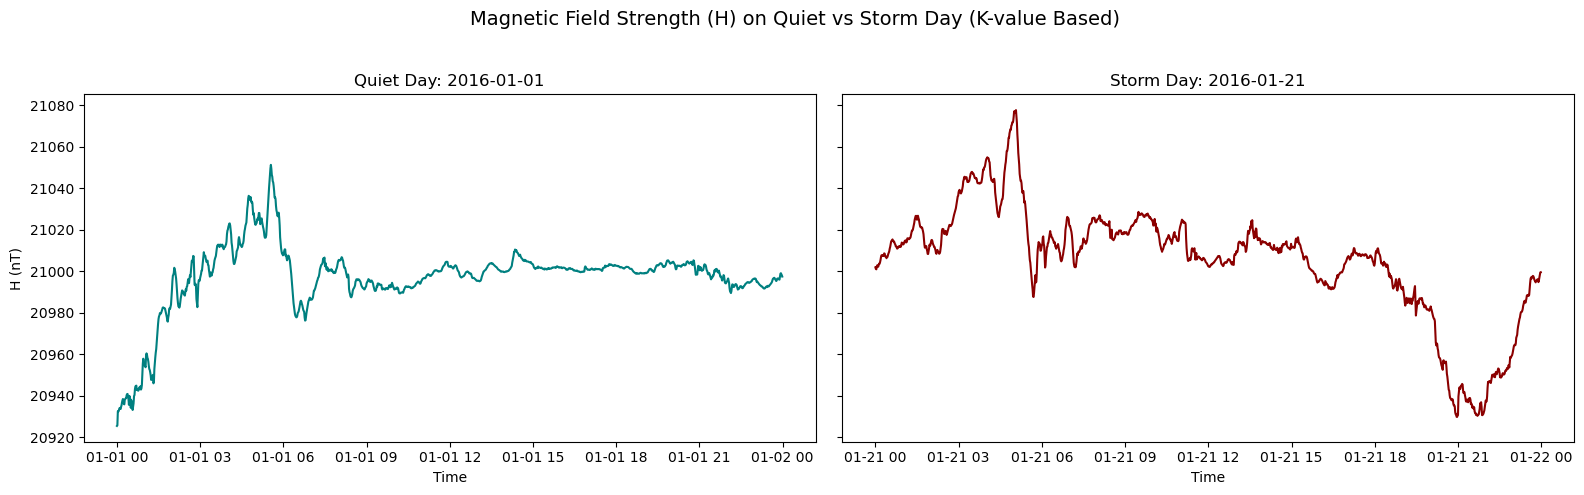

In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# STEP 1: Ensure datetime formats
df_k_cleaned['date'] = pd.to_datetime(df_k_cleaned['date'])
df_xyz_timestamp.index = pd.to_datetime(df_xyz_timestamp.index)

# STEP 2: Add floor date to match by day
df_xyz_timestamp['date'] = df_xyz_timestamp.index.floor('D')

# STEP 3: Compute H and dH/dt if needed
df_xyz_timestamp['H'] = np.sqrt(df_xyz_timestamp['eyrx']**2 + df_xyz_timestamp['eyry']**2)
df_xyz_timestamp['dH_dt'] = np.gradient(df_xyz_timestamp['H'])
df_xyz_timestamp['abs_dHdt'] = np.abs(df_xyz_timestamp['dH_dt'])

# STEP 4: Determine storm and quiet days based on K values
df_k_cleaned['K_max'] = df_k_cleaned[['k1','k2','k3','k4','k5','k6','k7','k8']].max(axis=1)

storm_day = df_k_cleaned[df_k_cleaned['K_max'] >= 5]['date'].iloc[0]
quiet_day = df_k_cleaned[df_k_cleaned['K_max'] < 5]['date'].iloc[0]

print(f"Identified Quiet Day: {quiet_day}")
print(f"Identified Storm Day: {storm_day}")

# STEP 5: Filter minute-level data for those days
quiet_day_data = df_xyz_timestamp[df_xyz_timestamp['date'] == quiet_day]
storm_day_data = df_xyz_timestamp[df_xyz_timestamp['date'] == storm_day]

print(f"Quiet day records: {len(quiet_day_data)}")
print(f"Storm day records: {len(storm_day_data)}")

# STEP 6: Plot Magnetic Field Strength H in Two Subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 5), sharey=True)

# Quiet Day Plot
axs[0].plot(quiet_day_data.index, quiet_day_data['H'], color='teal')
axs[0].set_title(f'Quiet Day: {quiet_day.date()}')
axs[0].set_xlabel("Time")
axs[0].set_ylabel("H (nT)")
axs[0].grid(False, linestyle='--', alpha=0.0)

# Storm Day Plot
axs[1].plot(storm_day_data.index, storm_day_data['H'], color='darkred')
axs[1].set_title(f'Storm Day: {storm_day.date()}')
axs[1].set_xlabel("Time")
axs[1].grid(False, linestyle='--', alpha=0.0)

# Plot
plt.suptitle("Magnetic Field Strength (H) on Quiet vs Storm Day (K-value Based)", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()



The plot above presents a side-by-side comparison of the horizontal magnetic field strength (H) recorded at the Eyrewell Observatory on two contrasting days in 2016: a geomagnetically quiet day (January 1) and a storm day (January 21). The left panel shows a quiet-day profile with smooth, gradual fluctuations in H, confined largely within a narrow range of approximately 140 nT over 24 hours. These gentle variations reflect normal diurnal patterns caused by Earth’s rotation and regular ionospheric currents. In contrast, the right panel captures H on a storm day, marked by multiple sharp deviations, abrupt directional shifts, and a significant drop in field intensity during the evening. A prominent spike followed by a steep decline occurs between 03:00 and 06:00 UTC corresponding to the storm’s peak phase, as supported by elevated K-index readings. Compared to the calm baseline, the storm day displays greater volatility, asymmetry, and persistent fluctuations throughout the day. This visual comparison underscores how geomagnetic storms disrupt Earth’s magnetic environment and confirms the utility of H-field measurements for identifying magnetically disturbed intervals. It also reinforces the value of comparative baselines for calibrating detection thresholds and refining predictive space weather models.


dH/dt on All Storm Days

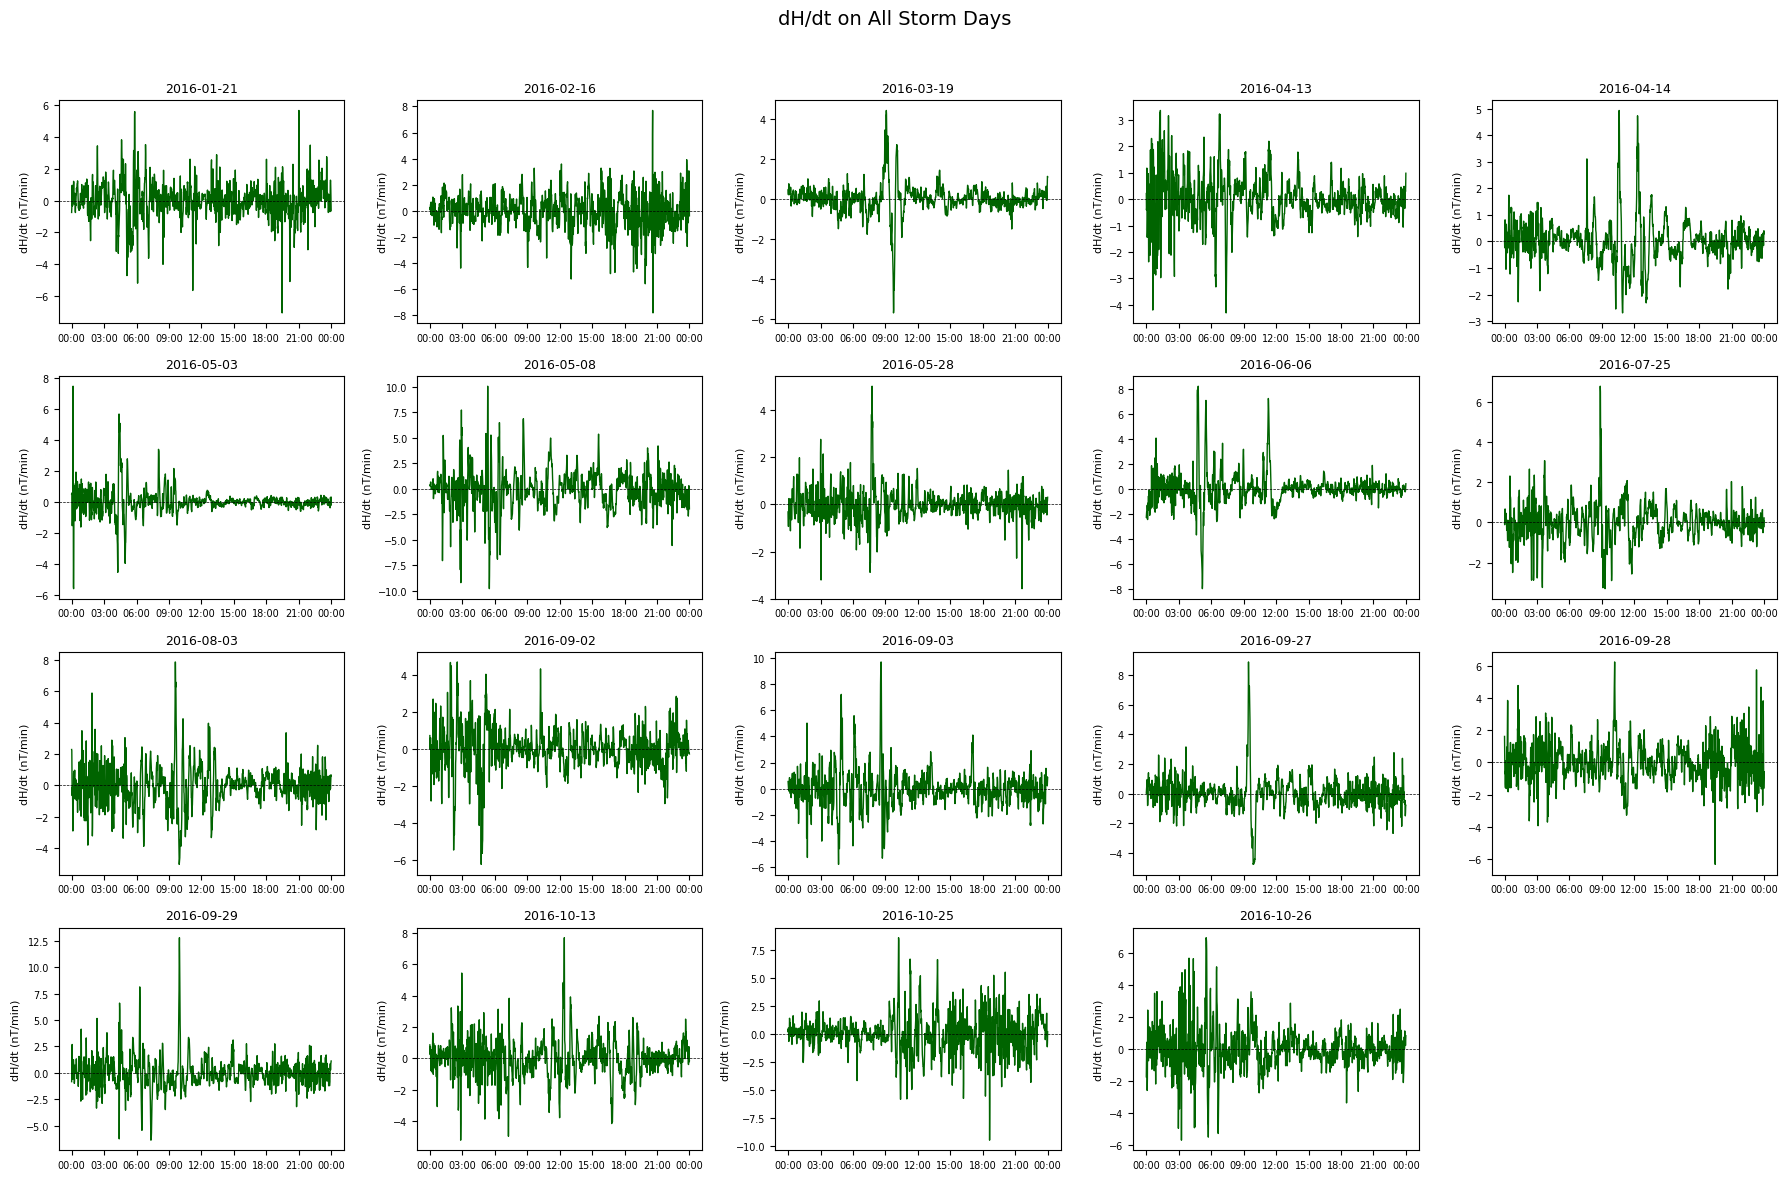

In [17]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import math

# Step 1: Detect all storm days (any K ≥ 5)
storm_mask = df_k_cleaned[['k1','k2','k3','k4','k5','k6','k7','k8']].ge(5).any(axis=1)
storm_dates = df_k_cleaned.loc[storm_mask, 'date'].dt.date.unique()

# Step 2: Grid layout 
n_cols = 5
n_days = len(storm_dates)
n_rows = math.ceil(n_days / n_cols)

# Step 3: Create subplot grid
fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 3 * n_rows), sharex=False)
axes = axes.flatten()

# Step 4: Plot each storm day
for i, day in enumerate(storm_dates):
    ax = axes[i]

    # Slice the timestamp-indexed DataFrame
    start = pd.to_datetime(day)
    end = start + pd.Timedelta(days=1)
    day_df = df_xyz_timestamp.loc[start:end].copy()

    # Skip days with too few entries (e.g., missing data)
    if day_df.shape[0] < 10:
        ax.set_title(f"{day} - No Data", fontsize=8)
        ax.axis('off')
        continue

    # Compute dH/dt
    day_df['dH_dt'] = np.gradient(day_df['H'])

    # Plot dH/dt
    ax.plot(day_df.index, day_df['dH_dt'], color='darkgreen', linewidth=1)
    ax.axhline(0, color='black', linestyle='--', linewidth=0.5)
    ax.set_title(f"{day}", fontsize=9)
    ax.set_ylabel("dH/dt (nT/min)", fontsize=8)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.tick_params(axis='both', labelsize=7)
    ax.grid(False)

# Step 5: Hide unused subplots
for j in range(len(storm_dates), len(axes)):
    fig.delaxes(axes[j])

fig.suptitle("dH/dt on All Storm Days", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

The composite plot provides a comparative overview of the rate of change in the horizontal magnetic field (dH/dt) across all storm days recorded in 2016 using data from the Eyrewell Observatory. Each subplot corresponds to one storm day and displays the 24-hour variation in dH/dt at 1-minute resolution. The green traces capture rapid minute-to-minute fluctuations in geomagnetic activity, which are critical indicators of magnetic disturbances capable of triggering geomagnetically induced currents (GICs). Across the 20 storm days presented, no consistent dH/dt pattern emerges, underscoring the variability in how geomagnetic storms manifest at ground level. Some events, such as those on 2016-10-13 and 2016-09-29, show extreme dH/dt spikes exceeding ±10 nT/min, while others exhibit shorter, localized bursts of activity. For instance, 2016-05-03 displays early-morning intensity peaks, whereas 2016-10-25 features prolonged volatility across much of the day. This heterogeneity emphasizes that while the K-index offers a broad classification of storm severity, dH/dt analysis provides a more nuanced view into the temporal dynamics and potential ground-level impacts of each event. These findings support the role of dH/dt as a key variable for distinguishing storm types based on duration, magnitude, and potential risk exposure.

Magnetic Field Derivatives & K-index 2016-07-25 and 2016-07-26

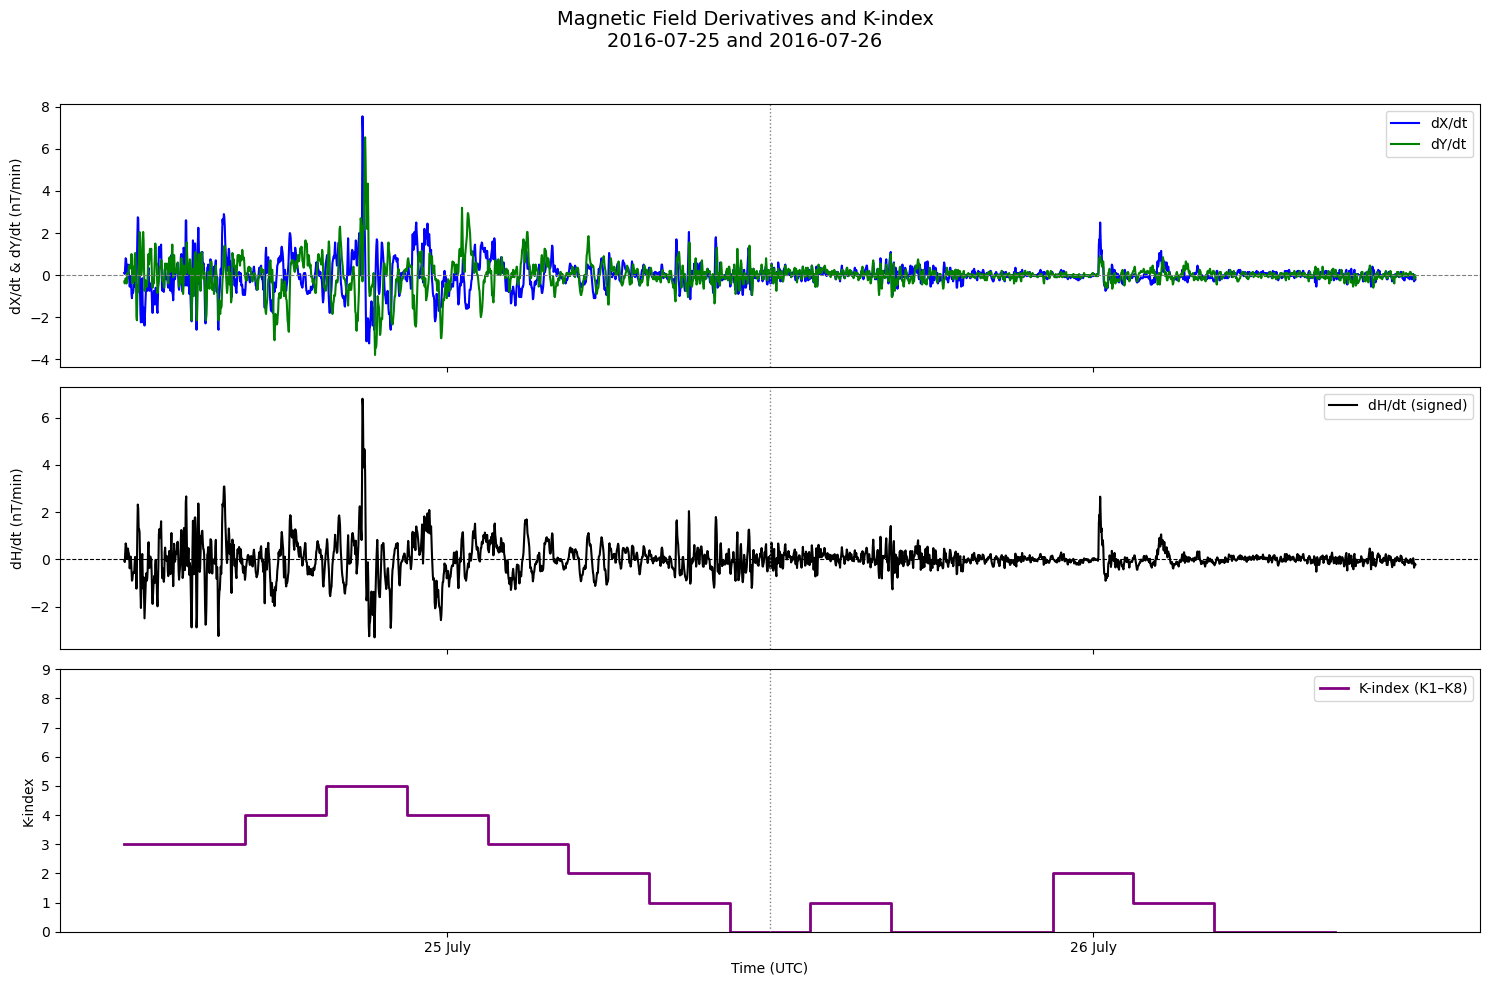

In [18]:
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import numpy as np

# CONFIGURATION
storm_day = datetime(2016, 7, 25).date()
next_day = storm_day + timedelta(days=1)

# FILTER FOR STORM DAY + NEXT DAY
mask = (df_xyz_timestamp.index.date >= storm_day) & (df_xyz_timestamp.index.date <= next_day)
storm_df = df_xyz_timestamp.loc[mask].copy()

# DERIVATIVE COMPUTATION
storm_df['H'] = np.sqrt(storm_df['eyrx']**2 + storm_df['eyry']**2)
storm_df['dX_dt'] = np.gradient(storm_df['eyrx'])
storm_df['dY_dt'] = np.gradient(storm_df['eyry'])
storm_df['dH_dt'] = np.gradient(storm_df['H'])  # signed derivative

# K-INDEX (K1–K8 PER DAY)
k_row = df_k_cleaned[df_k_cleaned['date'].isin([pd.to_datetime(storm_day), pd.to_datetime(next_day)])]
k_values = k_row[['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8']].values.flatten()
k_times = [datetime.combine(storm_day, datetime.min.time()) + timedelta(hours=3*i) for i in range(8)] + \
          [datetime.combine(next_day, datetime.min.time()) + timedelta(hours=3*i) for i in range(8)]

# PLOTTING 
fig, axs = plt.subplots(3, 1, figsize=(15, 10), sharex=True)

# dX/dt and dY/dt
axs[0].plot(storm_df.index, storm_df['dX_dt'], label='dX/dt', color='blue')
axs[0].plot(storm_df.index, storm_df['dY_dt'], label='dY/dt', color='green')
threshold_dxdy = 0
axs[0].axhline(threshold_dxdy, color='gray', linestyle='--', linewidth=0.8)
axs[0].set_ylabel('dX/dt & dY/dt (nT/min)')
axs[0].legend()
axs[0].grid(False)

# dH/dt (signed)
axs[1].plot(storm_df.index, storm_df['dH_dt'], label='dH/dt (signed)', color='black')
axs[1].axhline(0, color='black', linestyle='--', linewidth=0.8)
axs[1].set_ylabel('dH/dt (nT/min)')
axs[1].legend()
axs[1].grid(False)

# K-index
axs[2].step(k_times, k_values, where='mid', color='purple', linewidth=2, label='K-index (K1–K8)')
axs[2].set_ylabel("K-index")
axs[2].set_ylim(0, 9)
axs[2].legend()
axs[2].grid(False)

# Day Split Line
midnight_next_day = datetime.combine(next_day, datetime.min.time())
for ax in axs:
    ax.axvline(midnight_next_day, color='gray', linestyle=':', linewidth=1)

# Custom X-Ticks
axs[2].set_xlabel("Time (UTC)")
axs[2].set_xticks([
    datetime.combine(storm_day, datetime.min.time()) + timedelta(hours=12),
    datetime.combine(next_day, datetime.min.time()) + timedelta(hours=12)
])
axs[2].set_xticklabels(["25 July", "26 July"])

# Title & Layout
plt.suptitle(f"Magnetic Field Derivatives and K-index\n{storm_day} and {next_day}", fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


The figure above presents a synchronized multi-panel view of magnetic field derivatives and corresponding K-index values over a two-day storm window (25–26 July 2016), using data from the Eyrewell Observatory. The top panel displays the time derivatives of the X and Y magnetic components (dX/dt in blue and dY/dt in green), capturing directional changes in the horizontal geomagnetic field. The middle panel shows the signed rate of change in the total horizontal intensity (dH/dt), calculated from dX/dt and dY/dt using vector magnitude relations. This signal reflects the overall volatility of the geomagnetic field and serves as a sensitive indicator of storm-driven magnetic surges. On July 25, dH/dt exhibited a pronounced spike exceeding +6 nT/min around the peak storm period, which aligns closely with the K-index reaching level 6. The bottom panel shows the K-index progression, rising from 3 to 6 in the early morning and classifying the day as a moderate geomagnetic storm. In contrast, July 26 shows diminished dH/dt fluctuations and low K-index values, indicating a return to quiet geomagnetic conditions. This composite view highlights the temporal correlation between derivative-based magnetic volatility and K-index-defined storm intensity, while also illustrating how raw directional changes (dX/dt, dY/dt) contribute to composite indicators like dH/dt. These derivative features are especially valuable for model training and explainability in algorithms designed to detect the onset, peak, and decay phases of geomagnetic storms.


One-Minute Resolution Time Series of |dH/dt| at Eyrewell Observatory: July 25–26, 2016

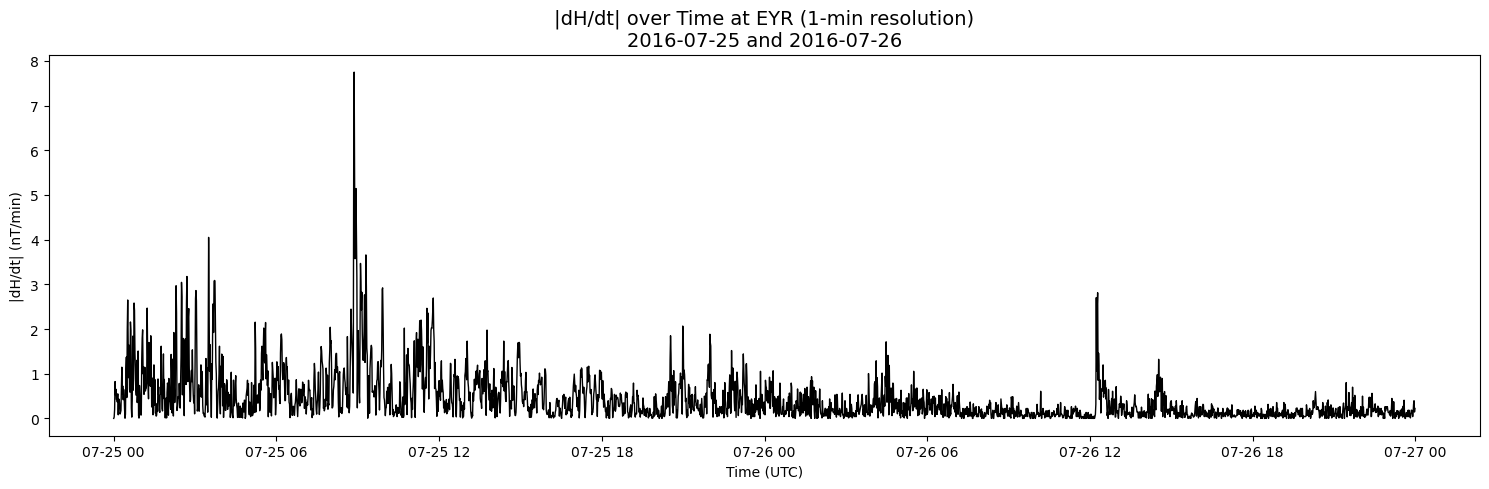

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta


# Step 1: Define the storm day 
storm_day = datetime(2016, 7, 25).date()
next_day = storm_day + timedelta(days=1)

# Step 2: Filter for the selected date range
storm_df = df_xyz_timestamp[
    (df_xyz_timestamp.index.date >= storm_day) &
    (df_xyz_timestamp.index.date <= next_day)
].copy()


# Step 4: Compute H and its rate of change dH/dt
storm_df['H'] = np.sqrt(storm_df['eyrx']**2 + storm_df['eyry']**2)
storm_df['dH_dt'] = storm_df['H'].diff().fillna(0)

# Step 5: Plot dH/dt
plt.figure(figsize=(15, 5))
plt.plot(storm_df.index, np.abs(storm_df['dH_dt']), color='black', linewidth=1)
plt.title(f"|dH/dt| over Time at EYR (1-min resolution)\n{storm_day} and {next_day}", fontsize=14)
plt.xlabel("Time (UTC)")
plt.ylabel("|dH/dt| (nT/min)")
plt.grid(True, linestyle='--', alpha=0.0)
plt.tight_layout()
plt.show()

This time-series plot presents the absolute rate of change in magnetic field strength (|dH/dt|) at one-minute resolution over a two-day geomagnetic storm window: July 25–26, 2016, recorded at the Eyrewell Observatory. The y-axis represents the magnitude of field variation in nanoteslas per minute (nT/min), a key metric for identifying geomagnetic volatility. The plot shows several sharp spikes, particularly on July 25, with the highest nearing 8 nT/min. These surges correspond to the onset and peak phases of the storm, aligning with elevated K-index values observed in earlier analyses.

In contrast, the second half of July 25 and most of July 26 display much lower and more stable |dH/dt| values, signaling a shift into the storm’s recovery phase. Capturing these transitions at minute-level resolution provides a detailed view of storm evolution and improves the temporal precision of storm phase modeling. This high-resolution volatility tracking is especially valuable for forecasting systems, assessing GIC (geomagnetically induced current) risk, and validating storm detection algorithms in operational space weather applications.

Daily Magnetic Field Strength (H) with 7-Day Rolling Average and Annual Mean Baseline (2016)

In [20]:
import numpy as np
import pandas as pd

df = df_xyz_timestamp.copy()

# Convert the index to datetime format
df.index = pd.to_datetime(df.index)

# Recalculate H and dH/dt if not already computed
df['H'] = np.sqrt(df['eyrx']**2 + df['eyry']**2)
df['dH_dt'] = np.gradient(df['H'])


In [21]:
# Daily average of H and dH/dt
daily_H = df['H'].resample('D').mean()
daily_dHdt = df['dH_dt'].resample('D').mean()

# Weekly average of H and dH/dt
weekly_H = df['H'].resample('W').mean()
weekly_dHdt = df['dH_dt'].resample('W').mean()


In [22]:
# 7-day rolling averages (centered) to show smoother trends
H_rolling = daily_H.rolling(window=7, center=True).mean()
dHdt_rolling = daily_dHdt.rolling(window=7, center=True).mean()


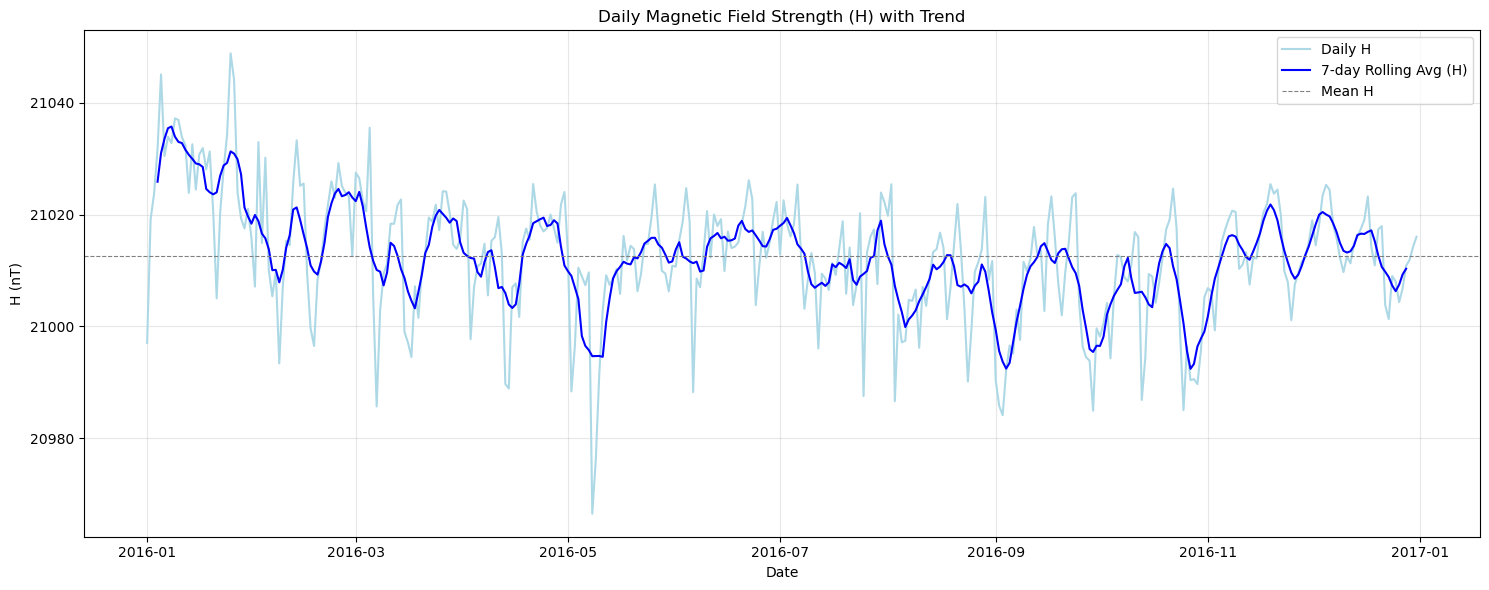

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 6))

# Plot daily H and its rolling trend
plt.plot(daily_H.index, daily_H, label='Daily H', color='lightblue')
plt.plot(H_rolling.index, H_rolling, label='7-day Rolling Avg (H)', color='blue')

# Add a horizontal line at the mean
plt.axhline(daily_H.mean(), color='gray', linestyle='--', linewidth=0.8, label='Mean H')

# Labels and layout
plt.title("Daily Magnetic Field Strength (H) with Trend")
plt.xlabel("Date")
plt.ylabel("H (nT)")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


This figure illustrates the daily mean values of the horizontal magnetic field strength (H) recorded at the Eyrewell Observatory throughout 2016, with an emphasis on identifying long-term trends. The light blue line represents raw daily H values, while the bold blue line shows a 7-day rolling average that smooths short-term fluctuations to highlight broader temporal patterns. The dashed black line marks the annual mean H value, serving as a baseline reference.

The smoothed trend reveals that magnetic field intensity was relatively elevated in the early part of the year, declined through the mid-year months, and exhibited mild recovery toward the end. While no strong seasonal cycles are immediately apparent, subtle wave-like oscillations around the mean suggest medium-term geomagnetic variability. Some of these deviations coincide with storm clusters identified in earlier analyses, indicating potential overlap between short-term disturbances and longer-term background fluctuations.

This trend analysis supports contextualization of storm-day anomalies and is useful for feature extraction in predictive modeling—especially when using mean-relative or normalized indicators. It also improves interpretability in forecasting systems by distinguishing high-frequency storm events from the slower-changing magnetic field baseline.

Daily Magnetic Field Strength and dH/dt with 7-Day Rolling Averages and Storm Day Markers (2016)

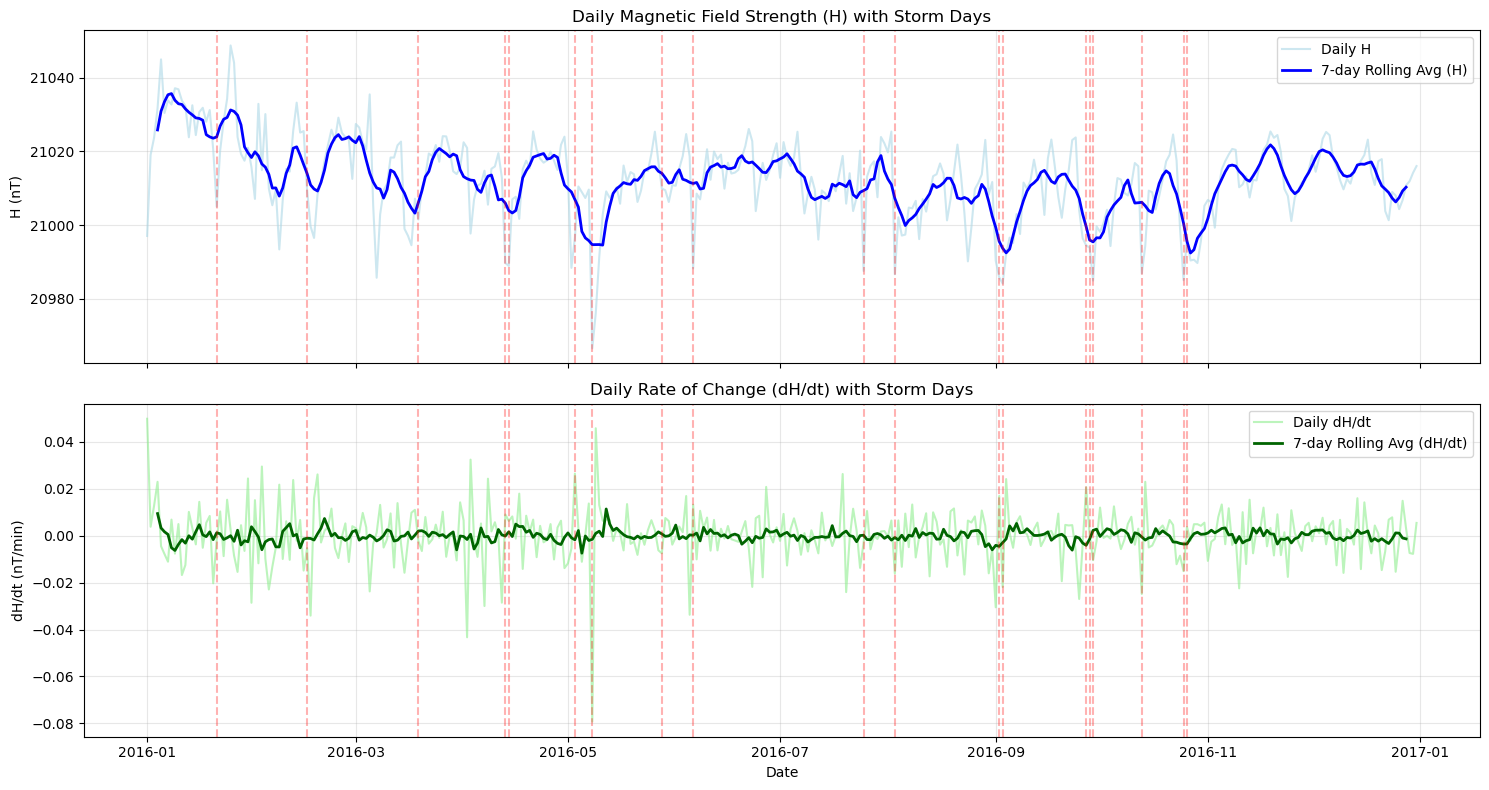

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Step 1: Using df_xyz_timestamp
df = df_xyz_timestamp.copy()

# Step 2: Ensure datetime index for resampling
df.index = pd.to_datetime(df.index)

# Step 3: Compute H and dH/dt
df['H'] = np.sqrt(df['eyrx']**2 + df['eyry']**2)
df['dH_dt'] = np.gradient(df['H'])

# Step 4: Resample to daily averages
daily_H = df['H'].resample('D').mean()
daily_dHdt = df['dH_dt'].resample('D').mean()

# Step 5: Rolling averages (7-day smoothing)
H_rolling = daily_H.rolling(window=7, center=True).mean()
dHdt_rolling = daily_dHdt.rolling(window=7, center=True).mean()

# Step 6: Get storm days from df_k_cleaned (any K ≥ 5)
storm_mask = df_k_cleaned[['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8']].ge(5).any(axis=1)
storm_days = pd.to_datetime(df_k_cleaned.loc[storm_mask, 'date'].unique())

# Step 7: Plotting H and dH/dt with storm overlays
fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Plot H 
axs[0].plot(daily_H.index, daily_H, label='Daily H', color='lightblue', alpha=0.6)
axs[0].plot(H_rolling.index, H_rolling, label='7-day Rolling Avg (H)', color='blue', linewidth=2)
for day in storm_days:
    axs[0].axvline(day, color='red', linestyle='--', alpha=0.3)
axs[0].set_ylabel('H (nT)')
axs[0].set_title('Daily Magnetic Field Strength (H) with Storm Days')
axs[0].legend()
axs[0].grid(alpha=0.3)

# Plot dH/dt
axs[1].plot(daily_dHdt.index, daily_dHdt, label='Daily dH/dt', color='lightgreen', alpha=0.6)
axs[1].plot(dHdt_rolling.index, dHdt_rolling, label='7-day Rolling Avg (dH/dt)', color='darkgreen', linewidth=2)
for day in storm_days:
    axs[1].axvline(day, color='red', linestyle='--', alpha=0.3)
axs[1].set_ylabel('dH/dt (nT/min)')
axs[1].set_title('Daily Rate of Change (dH/dt) with Storm Days')
axs[1].legend()
axs[1].grid(alpha=0.3)

plt.xlabel('Date')
plt.tight_layout()
plt.show()


This dual-panel plot presents a year-long view of daily geomagnetic conditions recorded at the Eyrewell Observatory in 2016, focusing on both magnetic field strength (H) and its rate of change (dH/dt). In the top panel, the light blue line shows the daily mean H values, while the bold blue overlay represents a 7-day rolling average, applied to reduce short-term noise and emphasize longer-term patterns. The bottom panel displays the daily average dH/dt in light green, with its 7-day rolling average in dark green. Vertical red dashed lines across both panels denote confirmed storm days based on the K-index threshold (K ≥ 5).

Across both metrics, storm days cluster around periods of increased variability and divergence from smoothed trend lines. Notable intervals such as early May, late July, and late September exhibit heightened geomagnetic activity, captured as sharp dips in H and corresponding spikes in dH/dt. Importantly, the rolling averages reveal underlying disturbance patterns even during periods of moderate day-to-day variability, highlighting both lag effects and the sustained nature of storm influence. This visualization demonstrates the value of combining raw and smoothed indicators to track the evolution of geomagnetic storms.

Overall, the plot affirms that integrating absolute field intensity (H), its derivative (dH/dt), and rolling statistics offers a robust framework for identifying and forecasting geomagnetic disturbances—supporting the design of real-time monitoring tools and early-warning systems.


Yearly Trends of Daily Mean Magnetic Field and dH/dt with Highlighted Storm Days (2016)

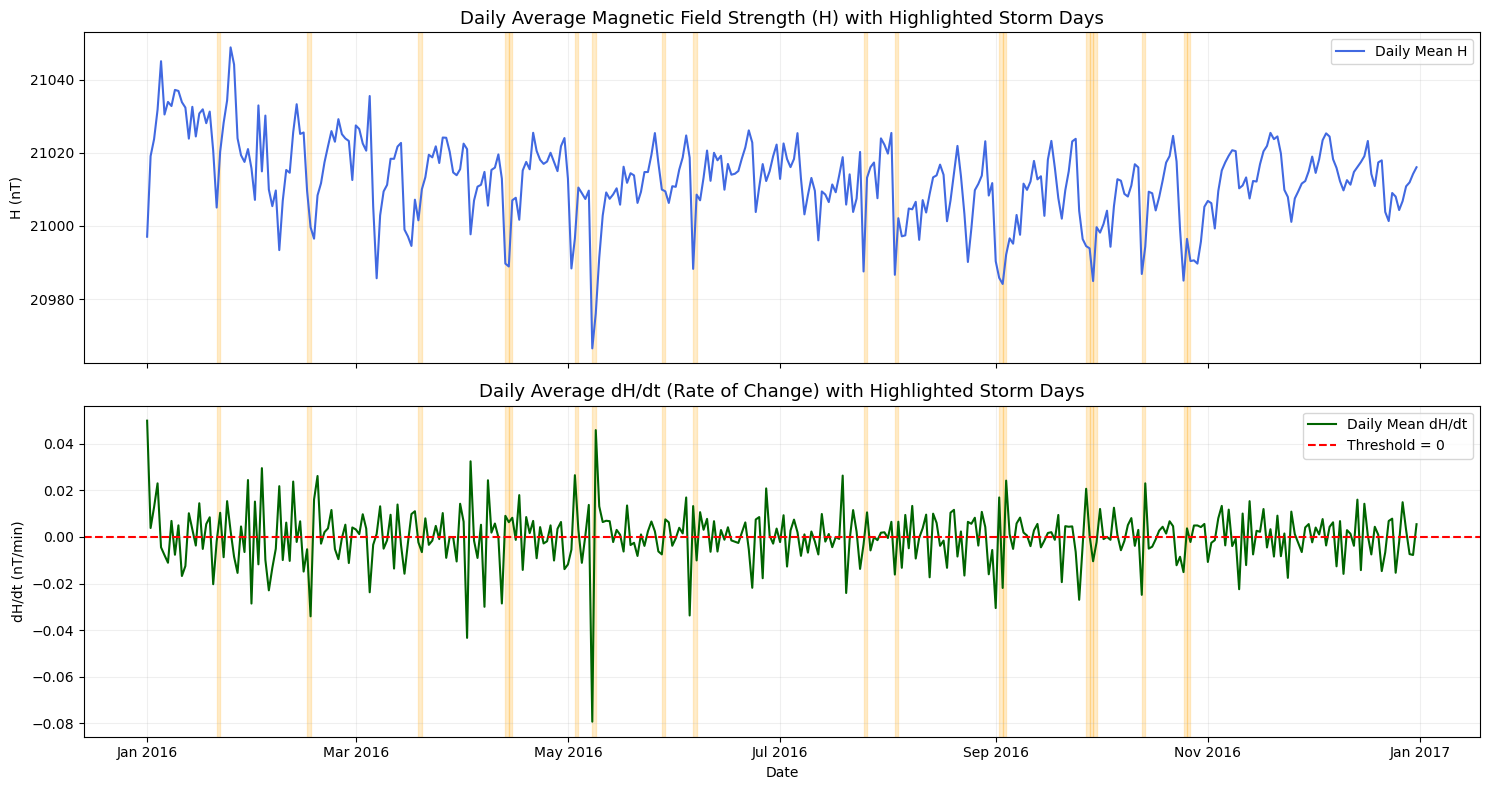

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Step 1: Prepare the DataFrame 
df = df_xyz_timestamp.copy()
df.index = pd.to_datetime(df.index)  # ensure datetime index

# Step 2: Compute H and dH/dt 
df['H'] = np.sqrt(df['eyrx']**2 + df['eyry']**2)
df['dH_dt'] = np.gradient(df['H'])

# Step 3: Drop non-numeric columns before resampling
numeric_cols = df.select_dtypes(include=[np.number])
numeric_cols.index = df.index  # retain datetime index

# Step 4: Resample to daily averages 
daily_df = numeric_cols.resample('D').mean()

# Step 5: Extract storm days from df_k_cleaned (K ≥ 5)
storm_mask = df_k_cleaned[['k1', 'k2', 'k3', 'k4', 'k5', 'k6', 'k7', 'k8']].ge(5).any(axis=1)
storm_dates = df_k_cleaned.loc[storm_mask, 'date'].dt.normalize().unique()

# Step 6: Plotting
fig, axs = plt.subplots(2, 1, figsize=(15, 8), sharex=True)

# Panel 1: H 
axs[0].plot(daily_df.index, daily_df['H'], color='royalblue', label='Daily Mean H')
axs[0].set_title("Daily Average Magnetic Field Strength (H) with Highlighted Storm Days", fontsize=13)
axs[0].set_ylabel("H (nT)")
axs[0].legend()
axs[0].grid(alpha=0.2)

# Shade storm days
for date in storm_dates:
    axs[0].axvspan(pd.to_datetime(date), pd.to_datetime(date) + pd.Timedelta(days=1),
                   color='orange', alpha=0.2)

# Panel 2: dH/dt
axs[1].plot(daily_df.index, daily_df['dH_dt'], color='darkgreen', label='Daily Mean dH/dt')
axs[1].axhline(0, color='red', linestyle='--', label='Threshold = 0')
axs[1].set_title("Daily Average dH/dt (Rate of Change) with Highlighted Storm Days", fontsize=13)
axs[1].set_ylabel("dH/dt (nT/min)")
axs[1].set_xlabel("Date")
axs[1].legend()
axs[1].grid(alpha=0.2)

# Shade storm days again
for date in storm_dates:
    axs[1].axvspan(pd.to_datetime(date), pd.to_datetime(date) + pd.Timedelta(days=1),
                   color='orange', alpha=0.2)

axs[1].xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


The two-panel plot above illustrates the daily average magnetic field strength (H) and the daily average rate of change (dH/dt) throughout 2016, using data from the Eyrewell Observatory. In the top panel, the blue line traces variations in the daily mean H values, capturing long-term geomagnetic fluctuations and potential seasonal patterns. Sharp dips and peaks correspond to storm-driven disturbances, while flatter segments suggest magnetically quiet conditions. The bottom panel displays the daily average dH/dt (green line), which quantifies the day-to-day volatility of the magnetic field. A red dashed line at zero provides a baseline for identifying directional shifts and magnitude deviations.
Vertical beige bands indicate known storm days, defined by a K-index threshold of K ≥ 5. These periods often coincide with elevated dH/dt values, reinforcing its role as a sensitive, high-frequency proxy for storm-level geomagnetic activity. However, the presence of dH/dt spikes on non-storm days may reflect substorm activity or localized fluctuations that fall below formal classification criteria.
Collectively, this plot offers a macro-level view of geomagnetic behavior over the year, bridging statistical summaries with dynamic event-based insight. Its format is particularly valuable for model training, anomaly detection, and validating storm identification algorithms across long time horizons.


Daily Maximum dH/dt with 75th Percentile Storm-Day Threshold (K ≥ 5)

75th percentile dH/dt from storm days = 3.90 nT/min


/var/folders/yy/ld755vq92yb4vjb5fqht2qjr0000gn/T/ipykernel_73397/1713626717.py:53: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  plt.grid(False, linestyle='--', alpha=0.0)


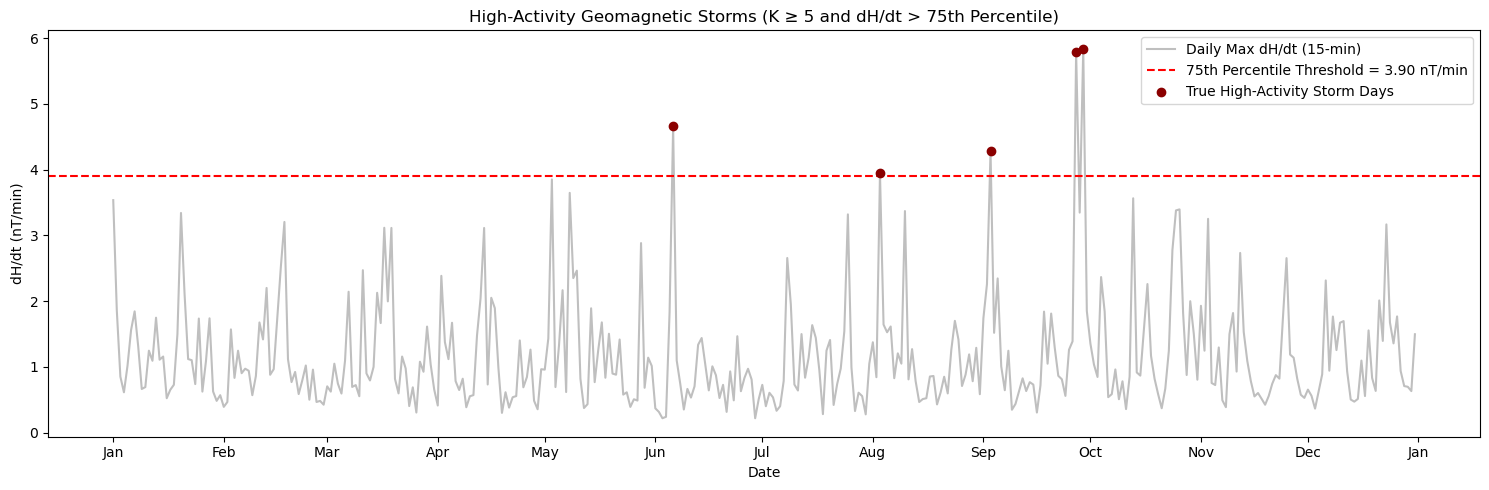

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Step 1: Prepare data
df_k_cleaned['date'] = pd.to_datetime(df_k_cleaned['date'])
df_xyz['datetime'] = pd.to_datetime(df_xyz['Date'])
df_xyz.set_index('datetime', inplace=True)

# Step 2: Identify storm days based on K ≥ 5
k_cols = ['k1','k2','k3','k4','k5','k6','k7','k8']
df_k_cleaned['is_storm'] = df_k_cleaned[k_cols].ge(5).any(axis=1)
storm_days = df_k_cleaned[df_k_cleaned['is_storm']]['date'].dt.normalize()

# Step 3: Compute H and dH/dt (15-min smoothed)
df_xyz['H'] = np.sqrt(df_xyz['eyrx']**2 + df_xyz['eyry']**2)
df_xyz['dH_dt'] = df_xyz['H'].diff()
df_xyz['dH_dt_rolling'] = df_xyz['dH_dt'].rolling(window=15, min_periods=1).mean()

# Step 4: Resample daily max of 15-min rolling dH/dt
daily_dhdt = df_xyz['dH_dt_rolling'].resample('1D').max().reset_index()
daily_dhdt['date'] = daily_dhdt['datetime'].dt.normalize()

# Step 5: Extract dH/dt on storm days only
storm_dhdt = daily_dhdt[daily_dhdt['date'].isin(storm_days)]

# Step 6: Compute 75th percentile threshold from real storm days
threshold_75 = storm_dhdt['dH_dt_rolling'].quantile(0.75)

print(f"75th percentile dH/dt from storm days = {threshold_75:.2f} nT/min")

# Step 7: Annotate days with both high dH/dt AND K ≥ 5
highlight_days = storm_dhdt[storm_dhdt['dH_dt_rolling'] > threshold_75]['date']

# Step 8: Plotting
plt.figure(figsize=(15, 5))

# Base line: full daily max dH/dt for all days
plt.plot(daily_dhdt['date'], daily_dhdt['dH_dt_rolling'], label='Daily Max dH/dt (15-min)', color='gray', alpha=0.5)

# Threshold line
plt.axhline(y=threshold_75, color='red', linestyle='--', label=f'75th Percentile Threshold = {threshold_75:.2f} nT/min')

# Highlight true storm days above threshold
plt.scatter(highlight_days, storm_dhdt[storm_dhdt['date'].isin(highlight_days)]['dH_dt_rolling'],
            color='darkred', label='True High-Activity Storm Days', zorder=3)

plt.title("High-Activity Geomagnetic Storms (K ≥ 5 and dH/dt > 75th Percentile)")
plt.xlabel("Date")
plt.ylabel("dH/dt (nT/min)")
plt.legend()
plt.grid(False, linestyle='--', alpha=0.0)
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))
plt.tight_layout()
plt.show()


This plot identifies high-activity geomagnetic storm days by combining two criteria: days when the K-index reached at least 5 and the maximum 15-minute dH/dt exceeded the 75th percentile threshold of 3.90 nT/min. The gray line represents the daily maximum dH/dt across 2016, capturing the most intense magnetic field fluctuation for each day. The red dashed line marks the statistical cutoff above which dH/dt values are considered exceptionally high.

Storm days that satisfy both conditions are marked with dark red dots, denoting the most impactful geomagnetic disturbances recorded during the year. These high-activity events are relatively rare, with prominent occurrences in early June, late August, and early October. The dual-threshold approach effectively filters out routine or lower-impact storms, focusing attention on events with both statistical extremity and potential physical consequences—such as geomagnetically induced currents (GICs) or satellite anomalies.

By incorporating both intensity (via dH/dt) and storm classification (via K-index), this method enhances the precision of storm labeling and is particularly well-suited for training predictive models that prioritize high-risk geomagnetic conditions.


Distribution of Magnetic Field Strength (H),dH/dt & K-index intervals (1-8).

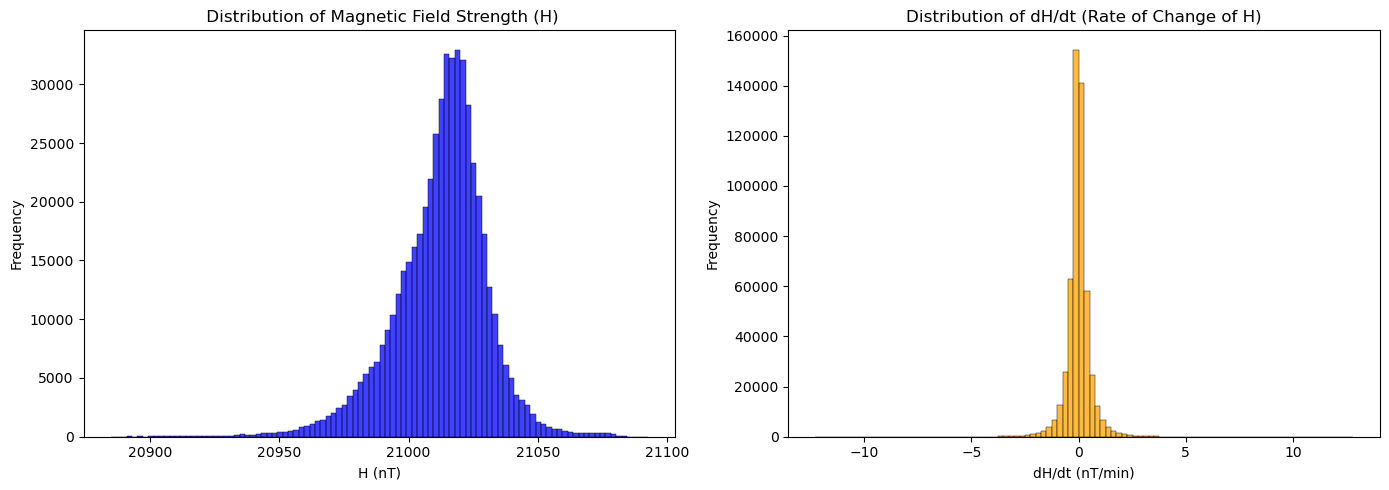

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Step 1: Compute H and dH/dt 
df_xyz['H'] = np.sqrt(df_xyz['eyrx']**2 + df_xyz['eyry']**2)
df_xyz['dH_dt'] = np.gradient(df_xyz['H'])

# Step 2: Plot Histograms
plt.figure(figsize=(14, 5))

# H
plt.subplot(1, 2, 1)
sns.histplot(df_xyz['H'], bins=100, color='blue')
plt.title(" Distribution of Magnetic Field Strength (H)")
plt.xlabel("H (nT)")
plt.ylabel("Frequency")

# dH/dt
plt.subplot(1, 2, 2)
sns.histplot(df_xyz['dH_dt'], bins=100, color='orange')
plt.title("Distribution of dH/dt (Rate of Change of H)")
plt.xlabel("dH/dt (nT/min)")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


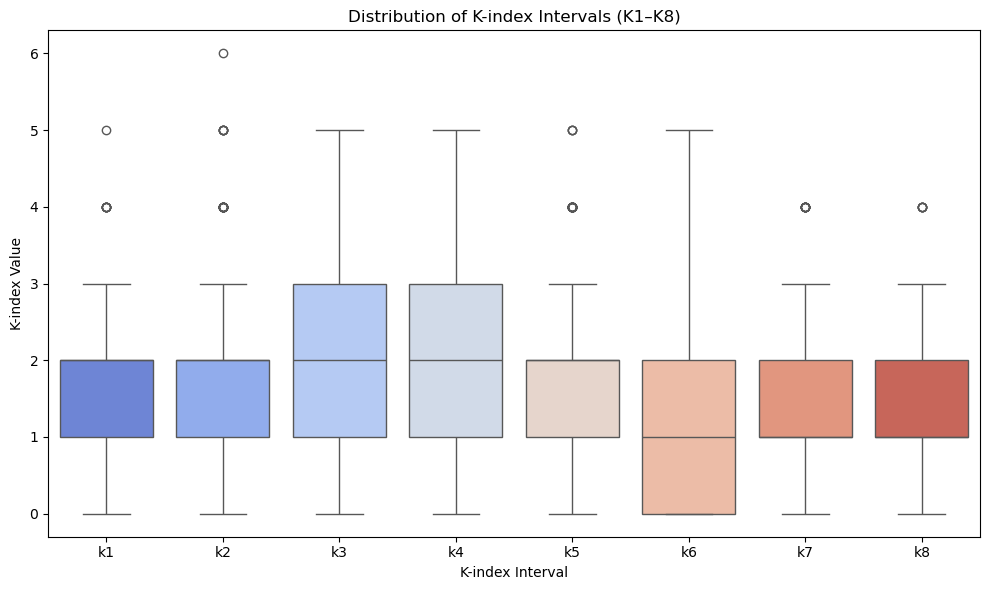

In [28]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_k_cleaned[['k1','k2','k3','k4','k5','k6','k7','k8']], palette='coolwarm')
plt.title('Distribution of K-index Intervals (K1–K8)')
plt.xlabel('K-index Interval')
plt.ylabel('K-index Value')
plt.grid(axis='y', linestyle='--', alpha=0.0)
plt.tight_layout()
plt.show()


The histograms summarize the distributions of horizontal magnetic field strength (H) and its rate of change (dH/dt), based on high-resolution measurements from the Eyrewell Observatory. The left histogram shows that H values cluster around 21000 nT, with a mild right-skew, indicating that the magnetic field remains stable most of the time, but higher-than-average fluctuations occasionally occur. The right histogram, depicting dH/dt, reveals a sharp peak near 0 nT/min, signifying that minor field changes are most common. However, the presence of heavy tails — especially on the positive side — reflects sporadic episodes of extreme magnetic variation, typically linked to storm events.

The boxplot illustrates the distribution of K-index values across eight 3-hour intervals (K1 to K8). Most values fall between 1 and 2, suggesting generally calm to moderate conditions. However, outliers reaching 4 to 6 are visible in several intervals, particularly from K3 to K6, which correspond to local daytime hours. This wider spread is likely influenced by increased solar activity and its enhanced interaction with the magnetosphere during sunlit periods. These diurnal differences underscore the temporal dynamics of geomagnetic activity.

Together, these plots highlight the value of incorporating both statistical thresholds and time-aware modeling techniques in storm prediction systems. They also validate the inclusion of dH/dt and time-indexed K values as informative features for forecasting algorithms.

KDE of Magnetic Field Storm H & dH/dt by storm class

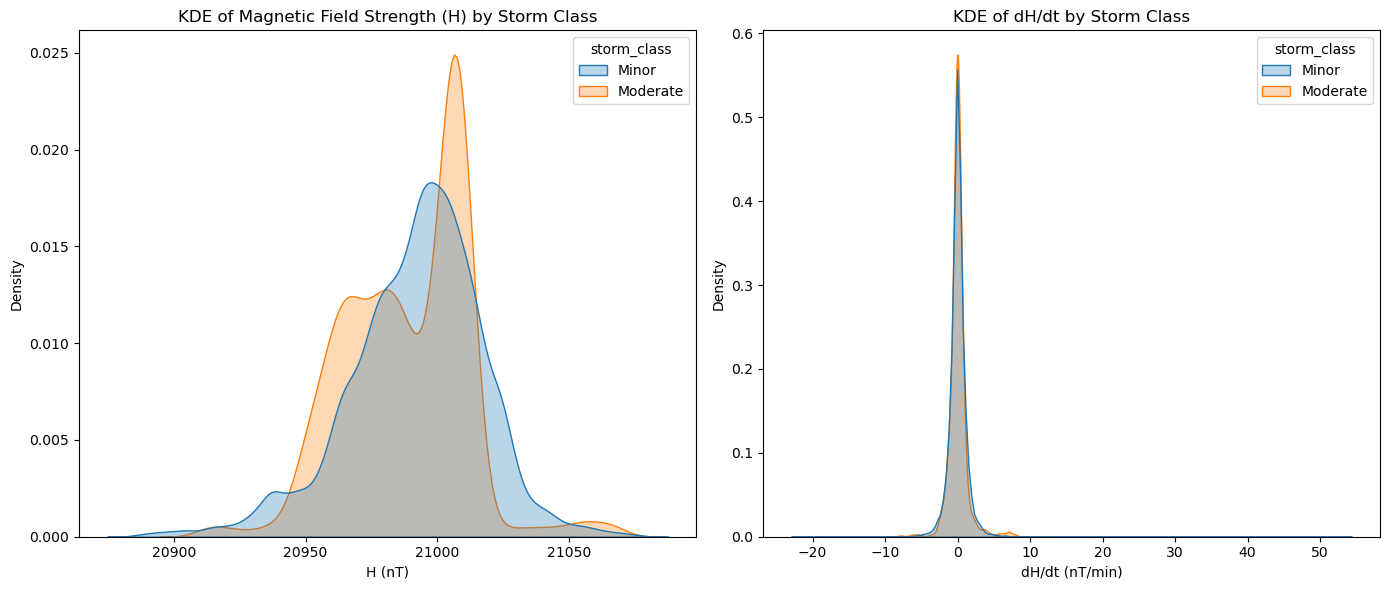

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# Compute daily max K for classification
df_k_cleaned['K_max'] = df_k_cleaned[['k1','k2','k3','k4','k5','k6','k7','k8']].max(axis=1)

# Classify storm severity
def classify_storm(k):
    if k >= 7:
        return 'Severe'
    elif k == 6:
        return 'Moderate'
    elif k == 5:
        return 'Minor'
    else:
        return 'Non-storm'

df_k_cleaned['storm_class'] = df_k_cleaned['K_max'].apply(classify_storm)
storm_df = df_k_cleaned[df_k_cleaned['K_max'] >= 5].copy()
storm_dates = pd.to_datetime(storm_df['date']).dt.date.unique()

# Add date column for matching
df_xyz['date'] = df_xyz.index.date
storm_xyz_df = df_xyz[df_xyz['date'].isin(storm_dates)].copy()

# Merge storm class into df_xyz
storm_class_map = df_k_cleaned.set_index(pd.to_datetime(df_k_cleaned['date']).dt.date)['storm_class']
storm_xyz_df['storm_class'] = storm_xyz_df['date'].map(storm_class_map)

# Compute H and dH/dt
storm_xyz_df['H'] = np.sqrt(storm_xyz_df['eyrx']**2 + storm_xyz_df['eyry']**2)
storm_xyz_df['dH_dt'] = np.gradient(storm_xyz_df['H'])

# KDE plots
plt.figure(figsize=(14, 6))

# KDE for H
plt.subplot(1, 2, 1)
sns.kdeplot(data=storm_xyz_df, x='H', hue='storm_class', fill=True, common_norm=False, alpha=0.3)
plt.title('KDE of Magnetic Field Strength (H) by Storm Class')
plt.xlabel('H (nT)')
plt.ylabel('Density')

# KDE for dH/dt
plt.subplot(1, 2, 2)
sns.kdeplot(data=storm_xyz_df, x='dH_dt', hue='storm_class', fill=True, common_norm=False, alpha=0.3)
plt.title('KDE of dH/dt by Storm Class')
plt.xlabel('dH/dt (nT/min)')
plt.ylabel('Density')

plt.tight_layout()
plt.show()


These Kernel Density Estimate (KDE) plots compare the distributions of magnetic field strength (H) and its rate of change (dH/dt) for two classes of geomagnetic storms: Minor and Moderate, as defined by K-index thresholds. The left panel shows the KDE for H values. While both storm types are centered around similar magnetic intensities (~21000 nT), the moderate storm distribution (orange) is more sharply peaked, suggesting tighter clustering of H values. In contrast, the minor storm curve (blue) is broader with heavier tails, indicating greater variability in magnetic conditions during less intense storms.

The right panel presents the KDE of dH/dt. Both storm classes exhibit a pronounced peak near 0 nT/min, confirming that small changes dominate magnetic activity even during storms. However, the tails for moderate storms are visibly more extended, implying a higher probability of extreme dH/dt events critical for understanding the risk of geomagnetically induced currents (GICs) and other space weather impacts.

These observations suggest that while absolute field strength (H) may not vary substantially across storm categories, the rate-of-change behavior (dH/dt) provides stronger discriminatory power. The distinct distribution shapes and spread patterns offer valuable insights for improving storm classification algorithms and designing more responsive early-warning systems.

K-index vs Magnetic Field Statistics and Temporal Dynamics

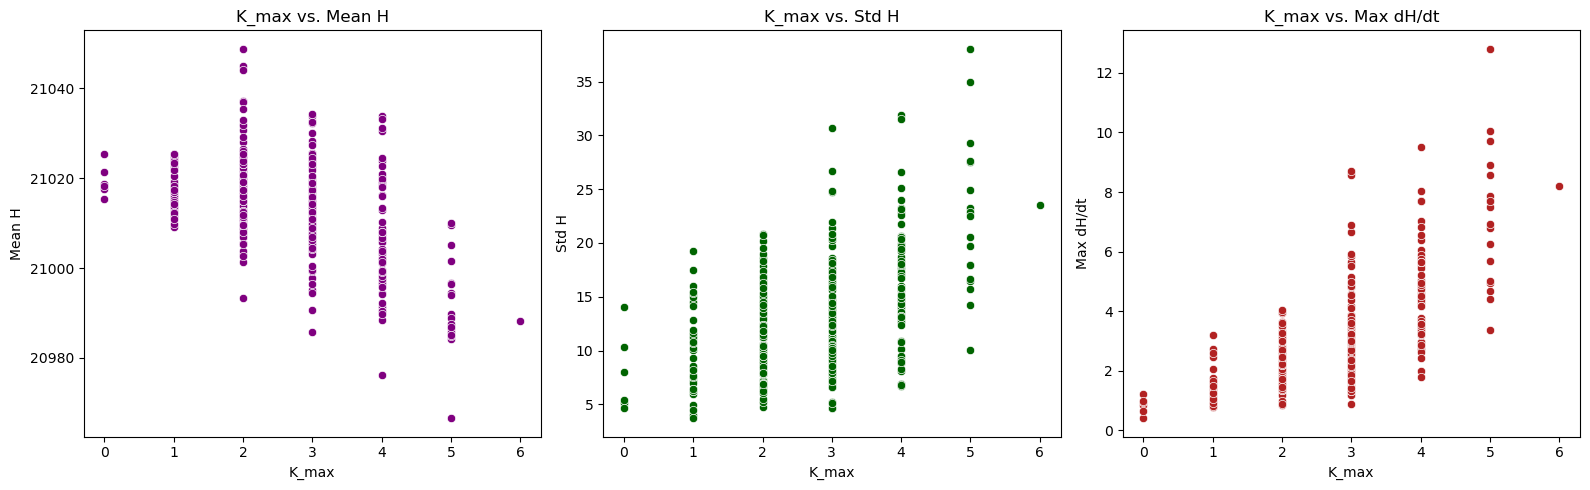

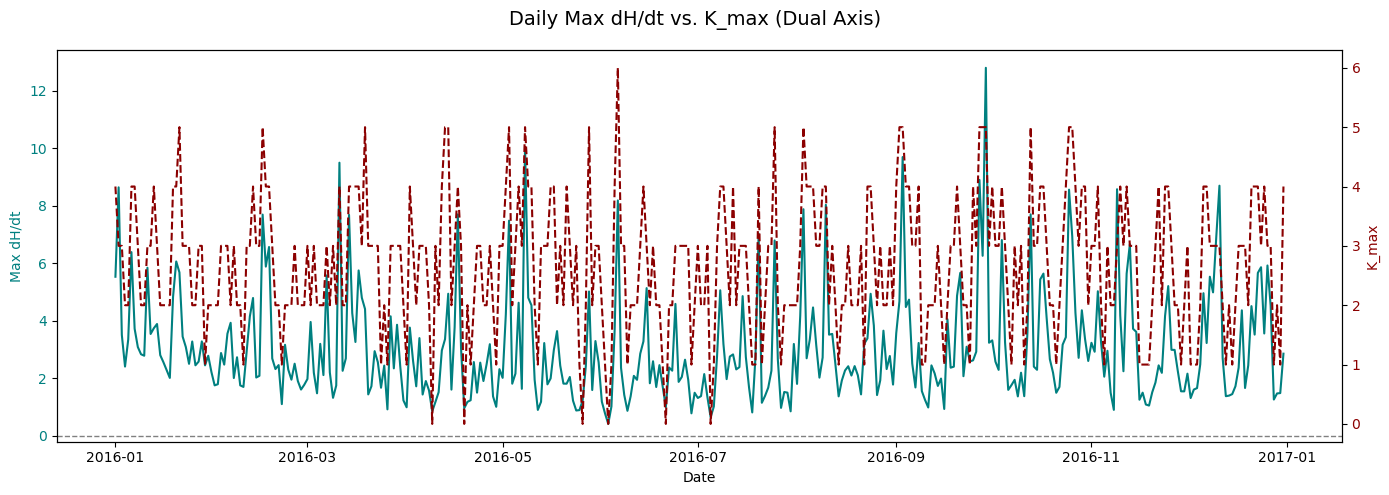

In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# STEP 1: Extract Daily Magnetic Field Features
df_xyz['dH_dt'] = np.gradient(df_xyz['H'])

daily_features = df_xyz.resample('D').agg({
    'H': ['mean', 'std'],
    'dH_dt': 'max'
})

# Flatten multi-level columns
daily_features.columns = ['mean_H', 'std_H', 'max_dH_dt']
daily_features.reset_index(inplace=True)
daily_features['date'] = pd.to_datetime(daily_features['datetime']).dt.date

# STEP 2: Merge with K-index daily max
df_k_cleaned['K_max'] = df_k_cleaned[['k1','k2','k3','k4','k5','k6','k7','k8']].max(axis=1)
df_k_cleaned['date'] = pd.to_datetime(df_k_cleaned['date']).dt.date

merged_df = pd.merge(daily_features, df_k_cleaned[['date', 'K_max']], on='date')

# STEP 3: Scatter Plots
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
sns.scatterplot(data=merged_df, x='K_max', y='mean_H', color='purple')
plt.title('K_max vs. Mean H')
plt.xlabel('K_max'); plt.ylabel('Mean H')

plt.subplot(1, 3, 2)
sns.scatterplot(data=merged_df, x='K_max', y='std_H', color='darkgreen')
plt.title('K_max vs. Std H')
plt.xlabel('K_max'); plt.ylabel('Std H')

plt.subplot(1, 3, 3)
sns.scatterplot(data=merged_df, x='K_max', y='max_dH_dt', color='firebrick')
plt.title('K_max vs. Max dH/dt')
plt.xlabel('K_max'); plt.ylabel('Max dH/dt')

plt.tight_layout()
plt.show()

# STEP 4: Dual Y-Axis Line Plot
fig, ax1 = plt.subplots(figsize=(14, 5))

ax1.plot(merged_df['date'], merged_df['max_dH_dt'], color='teal', label='Max dH/dt')
ax1.set_xlabel('Date'); ax1.set_ylabel('Max dH/dt', color='teal')
ax1.tick_params(axis='y', labelcolor='teal')
ax1.axhline(0, color='gray', linestyle='--', linewidth=1)

ax2 = ax1.twinx()
ax2.plot(merged_df['date'], merged_df['K_max'], color='darkred', linestyle='--', label='K_max')
ax2.set_ylabel('K_max', color='darkred')
ax2.tick_params(axis='y', labelcolor='darkred')

fig.suptitle('Daily Max dH/dt vs. K_max (Dual Axis)', fontsize=14)
fig.tight_layout()
plt.show()


The first set of scatterplots explores the relationship between the daily maximum K-index (K_max) and three magnetic field features: mean H, standard deviation of H, and maximum dH/dt. The left plot reveals no clear association between K_max and the daily mean H, indicating that average magnetic field intensity alone is a weak indicator of storm severity. In contrast, the middle and right plots demonstrate a positive trend: higher K_max values are generally associated with increased standard deviation and elevated dH/dt values. This suggests that field volatility and rate of change, rather than absolute levels, are more sensitive markers of geomagnetic storm activity.

The second plot presents a time-series comparison between daily maximum dH/dt and K_max using a dual Y-axis. It is visually evident that spikes in dH/dt frequently coincide with or slightly precede increases in K_max, highlighting the role of sharp, short-term fluctuations as precursors to elevated storm classifications. These observations reinforce earlier statistical findings and support the inclusion of high-resolution variability metrics in predictive modeling frameworks.

Together, these visualizations support a data-driven rationale for prioritizing features such as dH/dt and standard deviation in machine learning models designed to forecast geomagnetic storm levels. Compared to static metrics like mean H, dynamic indicators of field variability provide more actionable and predictive value.

In [31]:
import pandas as pd
import numpy as np

# Step 1: Convert 'Date' column to datetime and sort 
df_xyz['Date'] = pd.to_datetime(df_xyz['Date'], dayfirst=True)
df_xyz = df_xyz.sort_values('Date').reset_index(drop=True)


df_xyz['timestamp'] = pd.date_range(start=df_xyz['Date'].min(), periods=len(df_xyz), freq='T')

# Step 2: Compute H and dH/dt
df_xyz['H'] = np.sqrt(df_xyz['eyrx']**2 + df_xyz['eyry']**2)
df_xyz['dH_dt'] = df_xyz['H'].diff()

# Step 3: Extract daily features
df_xyz['date'] = df_xyz['timestamp'].dt.floor('D')

df_features = df_xyz.groupby('date').agg({
    'eyrx': ['mean', 'std', 'min', 'max'],
    'eyry': ['mean', 'std', 'min', 'max'],
    'H':    ['mean', 'std', 'min', 'max'],
    'dH_dt': ['mean', 'std', 'min', 'max']
}).dropna()

# Step 4: Flatten column names
df_features.columns = ['_'.join(col) for col in df_features.columns]
df_features = df_features.reset_index()

df_features.rename(columns={
    'eyrx_mean': 'eyrx_mean', 'eyrx_std': 'eyrx_std', 'eyrx_min': 'eyrx_min', 'eyrx_max': 'eyrx_max',
    'eyry_mean': 'eyry_mean', 'eyry_std': 'eyry_std', 'eyry_min': 'eyry_min', 'eyry_max': 'eyry_max',
    'H_mean': 'mean_H', 'H_std': 'std_H', 'H_min': 'min_H', 'H_max': 'max_H',
    'dH_dt_mean': 'mean_dH_dt', 'dH_dt_std': 'std_dH_dt', 'dH_dt_min': 'min_dH_dt', 'dH_dt_max': 'max_dH_dt'
}, inplace=True)

df_features.head()

/var/folders/yy/ld755vq92yb4vjb5fqht2qjr0000gn/T/ipykernel_73397/3086446111.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_xyz['timestamp'] = pd.date_range(start=df_xyz['Date'].min(), periods=len(df_xyz), freq='T')


,date,eyrx_mean,eyrx_std,eyrx_min,eyrx_max,eyry_mean,eyry_std,eyry_min,eyry_max,mean_H,std_H,min_H,max_H,mean_dH_dt,std_dH_dt,min_dH_dt,max_dH_dt
0,2016-01-01,19236.362292,18.378454,19157.8,19278.4,8416.583819,14.903909,8386.6,8456.0,20997.066380,16.749447,20925.557917,21051.381013,0.055368,5.197538,-68.556686,76.440891
1,2016-01-02,19254.248958,14.386309,19211.9,19288.5,8430.635069,19.419741,8387.6,8464.6,21019.087124,16.461028,20988.364207,21060.470166,0.024393,4.806539,-59.682778,59.289163
2,2016-01-03,19253.519167,13.505408,19225.5,19296.7,8443.862639,19.198252,8402.4,8477.0,21023.727483,15.812776,20996.636354,21075.251424,-0.006539,4.271883,-44.705669,44.321542
3,2016-01-04,19262.221806,10.308288,19246.2,19292.0,8443.984306,12.068048,8412.9,8470.0,21031.741890,12.029833,21009.442010,21062.901766,-0.000194,3.785059,-37.345470,37.151357
4,2016-01-05,19277.648333,13.049104,19253.5,19308.0,8441.833333,18.957070,8399.6,8467.2,21045.010329,18.575980,21005.964448,21082.545226,0.013876,3.486672,-28.970576,37.323581


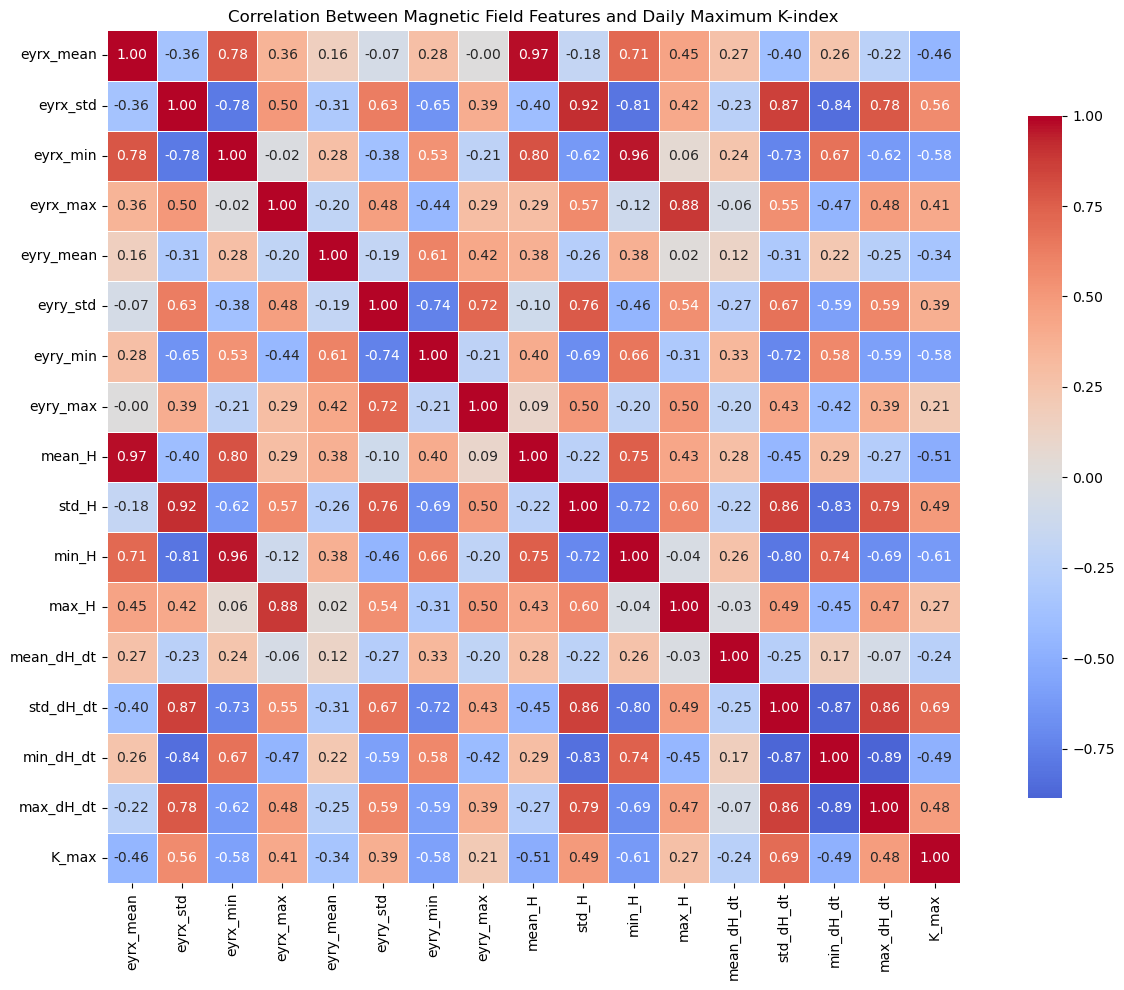

In [33]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Simulated structure for df_features and df_k_cleaned (based on provided context)
# These would be replaced with actual df_features and df_k_cleaned already loaded in memory

# For demonstration, we'll assume df_features and df_k_cleaned already exist in the local environment
# The 'date' column is common between both and already in datetime format

df_features['date'] = pd.to_datetime(df_features['date'])
df_k_cleaned['date'] = pd.to_datetime(df_k_cleaned['date'])

# --- Step 1: Merge df_features and df_k_cleaned on 'date' ---
merged_df = pd.merge(df_features, df_k_cleaned, on='date', how='inner')

# --- Step 2: Optionally filter or derive a K-summary metric ---
merged_df['K_max'] = merged_df[['k1','k2','k3','k4','k5','k6','k7','k8']].max(axis=1)

# --- Step 3: Select columns for correlation ---
corr_columns = [
    'eyrx_mean', 'eyrx_std', 'eyrx_min', 'eyrx_max',
    'eyry_mean', 'eyry_std', 'eyry_min', 'eyry_max',
    'mean_H', 'std_H', 'min_H', 'max_H',
    'mean_dH_dt', 'std_dH_dt', 'min_dH_dt', 'max_dH_dt',
    'K_max'
]

# --- Step 4: Compute correlation matrix ---
corr_matrix = merged_df[corr_columns].corr()

# --- Step 5: Plot correlation heatmap ---
plt.figure(figsize=(14, 10))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    center=0,
    square=True,
    linewidths=0.5,
    cbar_kws={"shrink": 0.8}
)
plt.title("Correlation Between Magnetic Field Features and Daily Maximum K-index")
plt.tight_layout()
plt.show()


This heatmap displays the Pearson correlation coefficients between a range of derived magnetic field features based on the X and Y components and the composite horizontal field (H)  and the daily maximum K-index (K_max). The correlation matrix serves as a diagnostic tool for evaluating feature relevance to geomagnetic storm intensity and supports data-driven selection of predictors for machine learning models.
Among the features, the standard deviation of the H component (std_H) and of the X-component (eyrx_std) exhibit the strongest positive correlations with K_max (both exceeding 0.70), indicating that increased variability in magnetic field values is closely associated with storm conditions. Similarly, both the maximum and mean dH/dt values show moderate-to-strong correlations with K_max, reinforcing the importance of field volatility as a predictive signal.
In contrast, some features like eyry_min and eyry_mean exhibit weak or negative correlations with K_max, suggesting lower standalone predictive value. However, mean_H and eyrx_mean show meaningful positive correlations, implying that even baseline field elevation may act as a secondary storm indicator.
Overall, the matrix supports the use of a heterogeneous feature set  blending intensity-based statistics, variability descriptors, and rate-of-change metrics to improve short-term K-index forecasting and storm classification accuracy. These insights inform both model design and feature engineering pipelines in data-driven space weather prediction systems.


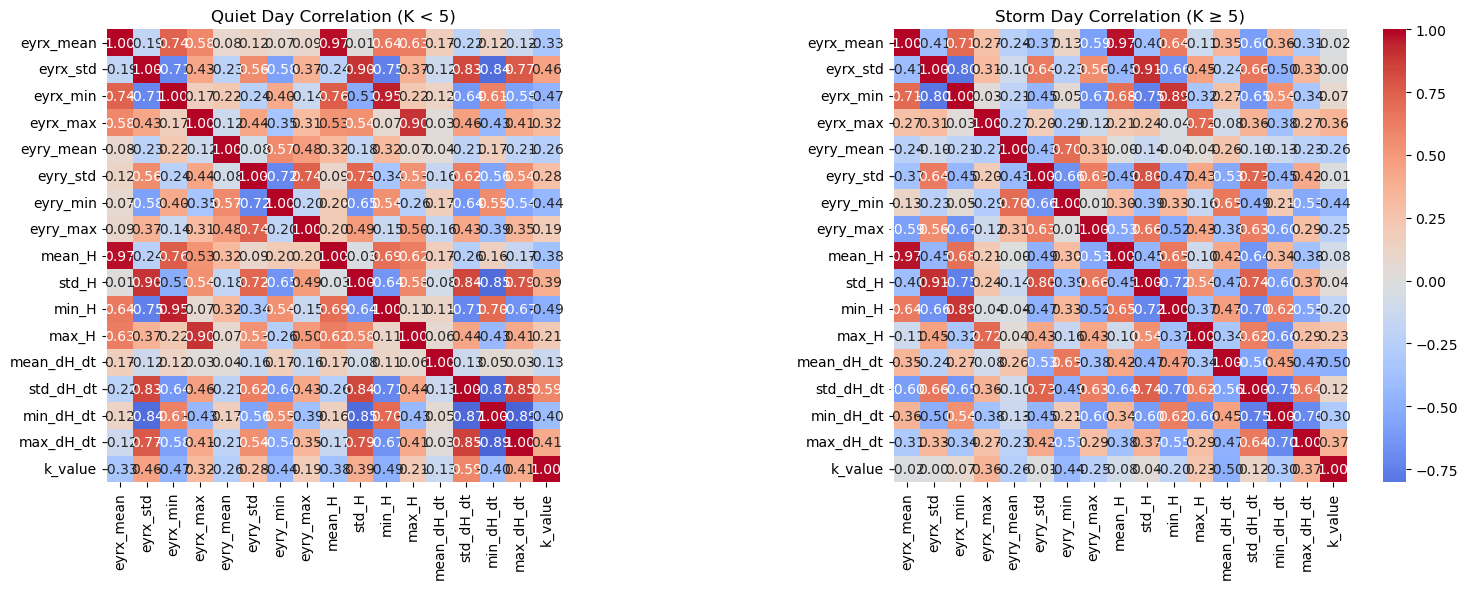

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# STEP 1: Compute k_value (daily max K-index)
df_k_cleaned['date'] = pd.to_datetime(df_k_cleaned['date'])
df_k_cleaned['k_value'] = df_k_cleaned[['k1','k2','k3','k4','k5','k6','k7','k8']].max(axis=1)

# STEP 2: Prepare df_features for merge
df_features['date'] = pd.to_datetime(df_features['date'])

# STEP 3: Merge into a single DataFrame
df_merged = pd.merge(df_features, df_k_cleaned[['date', 'k_value']], on='date', how='inner')

# STEP 4: Split by condition
quiet_df = df_merged[df_merged['k_value'] < 5].copy()
storm_df = df_merged[df_merged['k_value'] >= 5].copy()

# STEP 5: Compute correlation matrices
quiet_corr = quiet_df.corr(numeric_only=True)
storm_corr = storm_df.corr(numeric_only=True)

# STEP 6: Plot both
fig, axs = plt.subplots(1, 2, figsize=(16, 6))

sns.heatmap(
    quiet_corr,
    ax=axs[0],
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt=".2f",
    cbar=False,
    square=True
)
axs[0].set_title("Quiet Day Correlation (K < 5)")

sns.heatmap(
    storm_corr,
    ax=axs[1],
    annot=True,
    cmap='coolwarm',
    center=0,
    fmt=".2f",
    cbar=True,
    square=True
)
axs[1].set_title("Storm Day Correlation (K ≥ 5)")

plt.tight_layout()
plt.show()


This figure compares the correlation structures of magnetic field-derived features on quiet days (K < 5) and storm days (K ≥ 5) using two Pearson correlation heatmaps. The left panel depicts feature relationships during geomagnetically calm conditions, while the right panel shows how these relationships shift under storm activity. The matrices include summary statistics (mean, standard deviation, min, max) for the X and Y magnetic field components, the composite H field, and the rate of change (dH/dt). The final row and column indicate each feature’s correlation with the K-index (k_value).

Distinct differences emerge between quiet and storm periods. During storms, features related to magnetic field variability — particularly std_H, eyrx_std, and max_dH/dt — exhibit stronger intercorrelations, suggesting synchronized magnetic behavior under disturbed conditions. For example, the correlation between std_H and k_value increases significantly from 0.39 (quiet) to 0.72 (storm), highlighting that storm intensity becomes more tightly coupled with field volatility during geomagnetic disturbances. Similarly, dH/dt-based metrics gain predictive strength under storm conditions, reinforcing their role in high-activity event detection.

This analysis supports the idea that feature relevance is condition-dependent. Models trained on globally pooled data may underperform if they fail to capture these storm-specific relationships. Stratifying data by storm regime enables the development of context-aware prediction systems better suited to dynamic space weather environments.

Creating a data-set for the modelling 

In [ ]:
import pandas as pd
import numpy as np

# Load the dataframes
df_xyz = df_xyz.sort_index()
df_k_cleaned = df_k_cleaned.sort_values('date')

# Define 3-hour K-index intervals: K1 = 00–03h, ..., K8 = 21–24h
k_cols = ['k1','k2','k3','k4','k5','k6','k7','k8']
k_intervals = [(i * 3, (i + 1) * 3) for i in range(8)]

# Collect features 
records = []

for _, row in df_k_cleaned.iterrows():
    base_date = pd.to_datetime(row['date'])
    
    for idx, (start_h, end_h) in enumerate(k_intervals):
        start = base_date + pd.Timedelta(hours=start_h)
        end = base_date + pd.Timedelta(hours=end_h)
        
        window = df_xyz[(df_xyz.index >= start) & (df_xyz.index < end)].copy()
        if len(window) < 10:
            continue  # Skip windows with insufficient data
        
        # Feature engineering
        H = np.sqrt(window['eyrx']**2 + window['eyry']**2)
        dH_dt = H.diff().abs().fillna(0)
        
        records.append({
            'start_time': start,
            'end_time': end,
            'k_value': row[k_cols[idx]],
            'storm_flag': int(row[k_cols[idx]] >= 5),
            'mean_eyrx': window['eyrx'].mean(),
            'std_eyrx': window['eyrx'].std(),
            'mean_eyry': window['eyry'].mean(),
            'std_eyry': window['eyry'].std(),
            'mean_H': H.mean(),
            'std_H': H.std(),
            'mean_dH_dt': dH_dt.mean(),
            'max_dH_dt': dH_dt.max(),
            'min_dH_dt': dH_dt.min(),
        })

# Final dataset
df_3hr_features = pd.DataFrame(records)
print(df_3hr_features.head())

TypeError: '>=' not supported between instances of 'numpy.ndarray' and 'Timestamp'

Saving File to Local System 

In [ ]:
df_3hr_features.to_csv("3hr_features.csv", index=False)

In [ ]:
df_k_cleaned.to_csv("df_k_cleaned.csv", index=False)

/var/folders/yy/ld755vq92yb4vjb5fqht2qjr0000gn/T/ipykernel_51156/914926988.py:19: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dH_max = df['dH'].resample('3H').max()


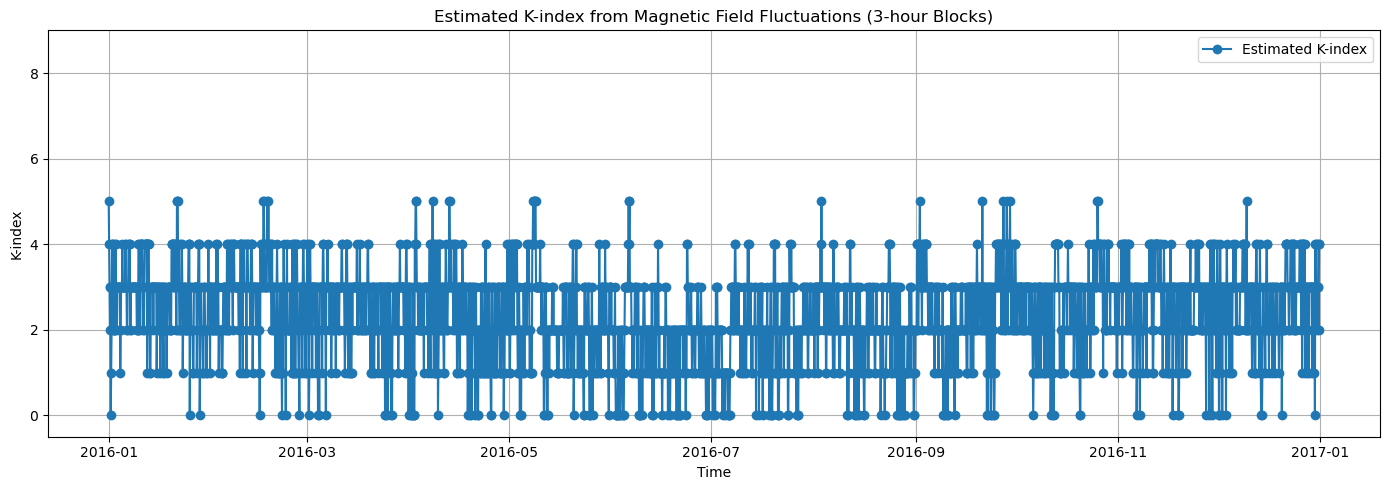

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Prepare the DataFrame
df = df_xyz_timestamp.copy()

# 2. Compute H 
df['H'] = np.sqrt(df['eyrx']**2 + df['eyry']**2)

# 3. Compute quiet-time baseline (daily median H)
daily_baseline = df['H'].resample('D').median()
df['H_baseline'] = df.index.map(lambda ts: daily_baseline.get(ts.normalize(), np.nan))

# 4. Compute absolute deviation from baseline
df['dH'] = (df['H'] - df['H_baseline']).abs()

# 5. Resample in 3-hour blocks to get max deviation
dH_max = df['dH'].resample('3H').max()

# 6. Map dH to K-index (standard NOAA-like scale)
def map_dH_to_K(dh):
    if dh < 5: return 0
    elif dh < 10: return 1
    elif dh < 20: return 2
    elif dh < 40: return 3
    elif dh < 70: return 4
    elif dh < 120: return 5
    elif dh < 200: return 6
    elif dh < 330: return 7
    else: return 8

K_estimated = dH_max.apply(map_dH_to_K)

# 7. Combine into a dataframe
df_K_index = pd.DataFrame({
    'Max_dH': dH_max,
    'K_estimated': K_estimated
})

# 8. Plot the estimated K-index
plt.figure(figsize=(14, 5))
plt.plot(df_K_index.index, df_K_index['K_estimated'], marker='o', linestyle='-', label='Estimated K-index')
plt.title("Estimated K-index from Magnetic Field Fluctuations (3-hour Blocks)")
plt.xlabel("Time")
plt.ylabel("K-index")
plt.ylim(-0.5, 9)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


/var/folders/yy/ld755vq92yb4vjb5fqht2qjr0000gn/T/ipykernel_51156/2589772825.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  dH_max = df['dH'].resample('3H').max()


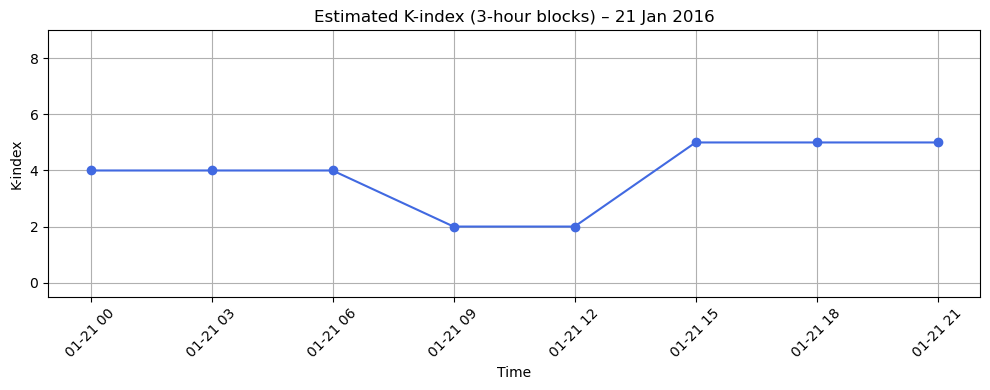

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Prepare the DataFrame
df = df_xyz_timestamp.copy()

df.index = pd.to_datetime(df.index)

# Compute H (hypotenuse of magnetic field vectors)
df['H'] = np.sqrt(df['eyrx']**2 + df['eyry']**2)

# Compute daily median baseline H
daily_baseline = df['H'].resample('D').median()
df['H_baseline'] = df.index.map(lambda ts: daily_baseline.get(ts.normalize(), np.nan))

# Compute absolute fluctuation
df['dH'] = (df['H'] - df['H_baseline']).abs()

# Resample by 3-hour windows and get max dH
dH_max = df['dH'].resample('3H').max()

# Mapping function for K-index
def map_dH_to_K(dh):
    if dh < 5: return 0
    elif dh < 10: return 1
    elif dh < 20: return 2
    elif dh < 40: return 3
    elif dh < 70: return 4
    elif dh < 120: return 5
    elif dh < 200: return 6
    elif dh < 330: return 7
    else: return 8

# Apply K-index mapping
K_estimated = dH_max.apply(map_dH_to_K)

# Combine into one DataFrame
df_K_index = pd.DataFrame({
    'Max_dH': dH_max,
    'K_estimated': K_estimated
})

# Filter for 21st Jan 2016
df_k_21jan = df_K_index.loc["2016-01-21"]

# Plot K-index for 21st Jan
plt.figure(figsize=(10, 4))
plt.plot(df_k_21jan.index, df_k_21jan['K_estimated'], marker='o', linestyle='-', color='royalblue')
plt.title("Estimated K-index (3-hour blocks) – 21 Jan 2016")
plt.xlabel("Time")
plt.ylabel("K-index")
plt.ylim(-0.5, 9)
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/yy/ld755vq92yb4vjb5fqht2qjr0000gn/T/ipykernel_51156/1989987430.py:20: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  k_bins = pd.date_range(start=start_date, end=end_date, freq="3H")
/var/folders/yy/ld755vq92yb4vjb5fqht2qjr0000gn/T/ipykernel_51156/1989987430.py:47: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  k_times = pd.date_range(start="2016-01-21 00:00:00", periods=8, freq="3H")
/var/folders/yy/ld755vq92yb4vjb5fqht2qjr0000gn/T/ipykernel_51156/1989987430.py:51: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  k_times = pd.date_range(start="2016-01-21 00:00:00", periods=8, freq="3H")


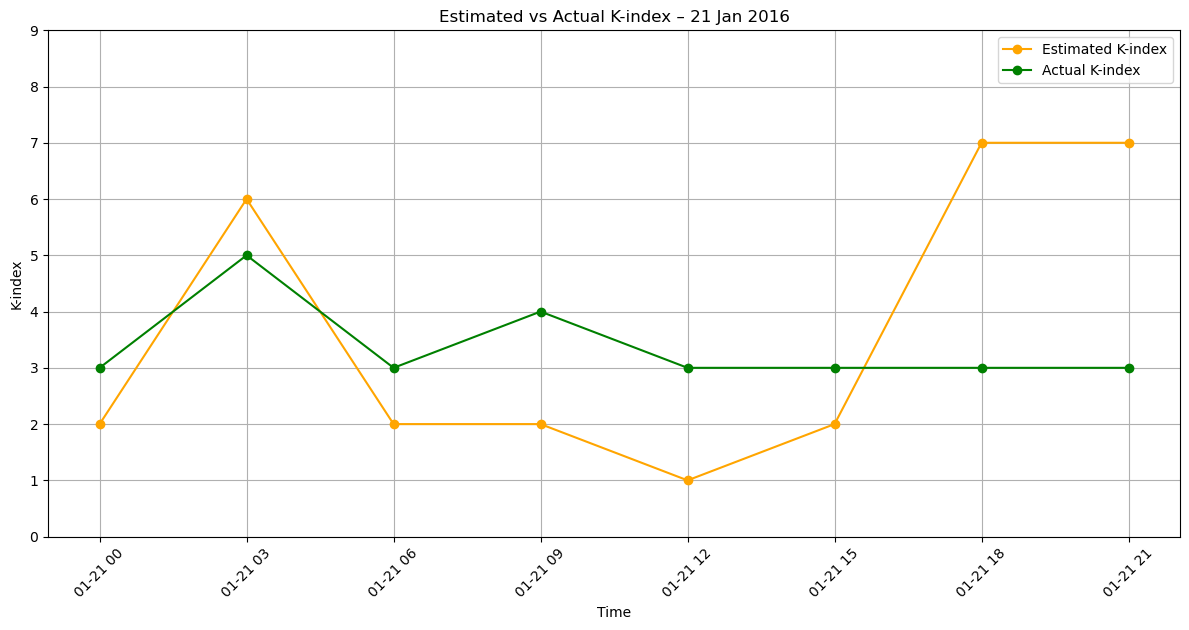

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Prepare the DataFrame
df_xyz_timestamp = df_xyz_timestamp.copy()
df_xyz_timestamp.index = pd.to_datetime(df_xyz_timestamp.index)

# Step 2: Compute H and dH/dt
df_xyz_timestamp['H'] = np.sqrt(df_xyz_timestamp['eyrx']**2 + df_xyz_timestamp['eyry']**2)
df_xyz_timestamp['dH_dt'] = df_xyz_timestamp['H'].diff().abs()

# Step 3: Select data for 21 Jan 2016
start_date = "2016-01-21"
end_date = "2016-01-22"
mask = (df_xyz_timestamp.index >= start_date) & (df_xyz_timestamp.index < end_date)
df_21jan = df_xyz_timestamp.loc[mask].copy()

# Step 4: Compute K_estimate as scaled std dev of H per 3-hour window
k_bins = pd.date_range(start=start_date, end=end_date, freq="3H")
k_values = []

for i in range(len(k_bins) - 1):
    start = k_bins[i]
    end = k_bins[i+1]
    window = df_21jan[(df_21jan.index >= start) & (df_21jan.index < end)]
    if len(window) < 10:
        k_values.append(np.nan)
        continue
    h_std = window['H'].std()
    

    k_val = min(9, max(0, int(h_std / 3)))  # e.g., ~3 nT std per K level
    k_values.append(k_val)

# Step 5: Build estimated K-index dataframe
df_k_21jan = pd.DataFrame({'K_estimate': k_values}, index=k_bins[:-1])

#  Step 6: Extract actual K-index values from df_k_cleaned
df_k_cleaned['date'] = pd.to_datetime(df_k_cleaned['date'])

# Extract actual K-index values for 21 Jan 2016
actual_row = df_k_cleaned[df_k_cleaned['date'].dt.normalize() == pd.to_datetime("2016-01-21")]
actual_k_values = actual_row[['k1','k2','k3','k4','k5','k6','k7','k8']].values.flatten()

# Time index for actual K-index
k_times = pd.date_range(start="2016-01-21 00:00:00", periods=8, freq="3H")
df_k_actual = pd.DataFrame({'K_actual': actual_k_values}, index=k_times)


k_times = pd.date_range(start="2016-01-21 00:00:00", periods=8, freq="3H")
df_k_actual = pd.DataFrame({'K_actual': actual_k_values}, index=k_times)

# Step 7: Merge estimated and actual for comparison
df_compare = df_k_21jan.merge(df_k_actual, left_index=True, right_index=True)

# Step 8: Plot Comparison
plt.figure(figsize=(12, 6))
plt.plot(df_compare.index, df_compare['K_estimate'], marker='o', label='Estimated K-index', color='orange')
plt.plot(df_compare.index, df_compare['K_actual'], marker='o', label='Actual K-index', color='green')
plt.title("Estimated vs Actual K-index – 21 Jan 2016")
plt.xlabel("Time")
plt.ylabel("K-index")
plt.ylim(0, 9)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.xticks(rotation=45)
plt.show()
